# 本文件说明
- 统计分析

# 基本设置

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import time

import requests,json
from sklearn.externals import joblib

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from toolkits.setup.date_time import get_day_list
from toolkits.setup import specific_func
specific_func.set_ch_pd()

## 一些函数

In [3]:
def plot_cor(count_data, day_thing, title):
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    rects = count_data[['al_cor', 'al_uncor']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('num', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['al-cor', 'al-uncor'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    count_data[['al_cor_rate', 'al_uncor_rate']].plot(x = count_data['publishtime'],
                                              kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(['al-cor-rate', 'al-uncor-rate'], loc='upper center')

    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in count_data['publishtime'].tolist():
            x = count_data['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()
    
    now = datetime.datetime.now().strftime("%Y-%m-%d")
    plt.savefig("figure\plot_cor\%s_%s.jpg"%(now, title))

    print(count_data.sort_values(by = 'publishtime', ascending = False).head())

In [4]:
def plot_tend(tend_count, day_thing, title):
    tend_counts = tend_count.set_index(["tendency", 'publishtime']).unstack('tendency')
    tend_counts.columns = ['neg', 'pos']
    tend_counts['sum'] = tend_counts.sum(axis = 1)
    tend_counts['neg_rate'] =  tend_counts['neg'] / tend_counts['sum']
    tend_counts['pos_rate'] =  tend_counts['pos'] / tend_counts['sum']
    tend_counts = tend_counts.reset_index('publishtime')

    tend_counts = tend_counts.sort_values(by = 'publishtime')
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    tend_counts[['neg', 'pos']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('N', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['neg N', 'pos N'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    tend_counts[['neg_rate', 'pos_rate']].plot(x = tend_counts['publishtime'],
                                             kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper center')
    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in tend_counts['publishtime'].tolist():
            x = tend_counts['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()
    
    now = datetime.datetime.now().strftime("%Y-%m-%d")
    plt.savefig("figure\plot_tend\%s_%s.jpg"%(now, title))
    
    print(tend_counts.sort_values(by = 'publishtime', ascending = False).head())

In [5]:
def get_server_res(data, url):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
    elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i]['cor']])
    parse_data = pd.DataFrame(parse_data, columns = ['id', 'cor'])    
    return parse_data, elapsed_time

In [6]:
def get_server_res_yjh(data, url, col_name):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
#     elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i][col_name]])
    parse_data = pd.DataFrame(parse_data, columns = ['id', col_name])    
    return parse_data #, elapsed_time

In [7]:
def get_period_data_for_training(human_additional, warning, url, folder, filename, flag):
    combined_data = pd.concat([human_additional, warning])
    print('去重前', combined_data.shape)
    combined_data = combined_data.drop_duplicates(subset = 'id')
    print('去重后', combined_data.shape)

    # predict
    data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
    if flag == 'circ':
        parse_data, elapsed_time = get_server_res(data, url)
    elif flag == 'cbrc':
        col_name = 'sec'
        parse_data = get_server_res_yjh(data, url, col_name)
        
    print(parse_data.shape)
    # parse_data.head()  

    parse_data.columns = ['id', 'predict_label']
    parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
    parse_data['label'] = ''
    # parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
    # parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
    print(parse_data.shape)
    # parse_data.head()

    combined_data = pd.merge(combined_data, parse_data, on  = 'id')
    print(combined_data.head())

    file_path = '%s/result/%s'%(folder, filename)
    combined_data[['id', 'predict_label', 
                   'label', 'title', 'content']].to_excel(file_path, index = False)

In [8]:
def get_class_data(class_count):
    class_count['c'] = class_count['publishtime'] + class_count['classify']
    class_count.index = range(class_count.shape[0])
    combined_count = {}
    for index in class_count.index:
        c = class_count.loc[index, 'c']
        if c not in combined_count:
            combined_count[c] = {}
            combined_count[c]['count'] = class_count.loc[index, 'count']
        else :
            combined_count[c]['count'] = combined_count[c]['count'] + class_count.loc[index, 'count']

        combined_count[c]['publishtime'] = class_count.loc[index, 'publishtime']
        combined_count[c]['classify'] = class_count.loc[index, 'classify']

    class_count = pd.DataFrame().from_dict(combined_count, orient = 'index')
    class_count.index = range(class_count.shape[0])    

    cor_class = class_count.set_index(['publishtime', 'classify']).unstack()#.reset_index('publishtime')
    cor_class['总量'] = cor_class['count'].sum(axis = 1)
    cor_class_1 = cor_class.copy()
    cor_class_1['非噪音'] = cor_class_1['总量'] - cor_class_1['count', '噪音']
    cor_class_1['非噪音-比例'] = cor_class_1['非噪音'] / cor_class_1['总量']
    cor_class_1['噪音-比例'] = cor_class_1['count', '噪音'] / cor_class_1['总量']
    # cor_class_1.sort_index(ascending = False).head()    
    
    for k in cor_class['count'].columns.tolist():
        cor_class['rate', k] = cor_class['count', k] / cor_class['总量']
#     cor_class.sort_index(ascending = False).head()

    count_data_7 = cor_class_1[['总量',  '非噪音', '非噪音-比例', '噪音-比例']]
    count_data_7.insert(2, '噪音', cor_class_1['count', '噪音'])
    count_data_7.columns = ['sum', 'al_cor', 'al_uncor', 'al_cor_rate', 'al_uncor_rate']
    count_data_7 = count_data_7.reset_index()

    cor_list = ['产品销售', '资本市场', '其他相关报道', '噪音'] # 3、4、7、8   
    count_data_4 = cor_class_1['count'][cor_list].sum(axis = 1).reset_index()
    ss = cor_class_1.reset_index()
    count_data_4 = pd.merge(count_data_4, ss[['总量', 'publishtime']], on = 'publishtime')
    count_data_4.columns = ['publishtime', 'al_uncor', 'sum']
    count_data_4['al_cor'] = count_data_4['sum'] - count_data_4['al_uncor']
    count_data_4['al_cor_rate'] = count_data_4['al_cor'] / count_data_4['sum']
    count_data_4['al_uncor_rate'] = count_data_4['al_uncor'] / count_data_4['sum']

    return cor_class_1, cor_class, count_data_7, count_data_4

In [162]:
# add_count = cbirc_add[cbirc_add['type'] == '建行北分']
# cbirc_day_thing
# title = "（建行北分）人工补录"
def plot_add(add_count, cbirc_day_thing, title):
    add_count = add_count.groupby('publishtime')['count'].sum()
    add_count = add_count.reset_index(['publishtime'])
    add_count = add_count.sort_values(by = 'publishtime')
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    add_count.plot(x = 'publishtime', y = 'count', kind = 'bar', figsize = (15, 6), ax = ax1)
    ax1.set_ylabel('数据量', fontsize = 16)
    ax1.set_title(title, fontsize = 20)

    ax2 = ax1.twinx()  # this is the important function
    ax2.set_ylim(0, 1)
    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in cbirc_day_thing:    
        if d in add_count['publishtime'].tolist():
            x = add_count['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()

    print(add_count.sort_values(by = 'publishtime', ascending = False).head())

# 参数设置

In [9]:
today = datetime.datetime.now()
today_str = today.strftime("%Y-%m-%d")
yesterday = today - datetime.timedelta(days=1)
yesterday_str = yesterday.strftime("%Y-%m-%d")
# data_folder = r'D:\XH\OneDrive\网智天元\4 银保监会\cbirc_获取用于人工判断数据\%s'% yesterday_str
# if not os.path.exists(data_folder):
#     os.makedirs(data_folder)

print('今天是：',today.strftime("%Y-%m-%d"))
print('昨天是：',yesterday_str)
print('统计的是昨天的数据，即 %s 的数据'%yesterday_str)
# print('文件存储位置: ', data_folder)

start_day = today - datetime.timedelta(days=31) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = today_str # yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

今天是： 2018-12-19
昨天是： 2018-12-18
统计的是昨天的数据，即 2018-12-18 的数据
start_day： 2018-11-18
end_day： 2018-12-19


In [10]:
label_dic={'补录':0,'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,
           '消费服务':6,'其他相关报道':7,'噪音':8,'交通':9,'环保':10}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{0: '补录',
 1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音',
 9: '交通',
 10: '环保'}

In [11]:
group = '1-新闻，2-论坛，3-博客，4-微博，5-纸媒，6-视频，7-外媒，8-广播，9-电视，11-微信，13-新闻客户端，15-推特'
group_dict = dict([x.split('-') for x in group.split('，')])
group_dict

{'1': '新闻',
 '11': '微信',
 '13': '新闻客户端',
 '15': '推特',
 '2': '论坛',
 '3': '博客',
 '4': '微博',
 '5': '纸媒',
 '6': '视频',
 '7': '外媒',
 '8': '广播',
 '9': '电视'}

In [12]:
proj_dic={'银监会':1,'保监会':2,'中国人寿':3,'建行北分':4,'中国人保':5,'安徽银监局':6}
proj_name_dict = {v: k for k, v in proj_dic.items()}
proj_name_dict

{1: '银监会', 2: '保监会', 3: '中国人寿', 4: '建行北分', 5: '中国人保', 6: '安徽银监局'}

# 保险业--旧
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：

## 特殊时间点

In [13]:
engine = specific_func.get_engine('circ')

In [14]:
circ_day_thing = [['2018-05-31', '上线倾向性模型'], 
             ['2018-06-12', '更新倾向性模型'], 
             ['2018-06-13', '更新倾向性模型'], 
             ['2018-06-15', '更新相关性模型'], 
             ['2018-06-19', '修复bug'], 
             ['2018-06-24', '更新相关性模型'],
             ['2018-06-24', '上线预警模型'], 
             ['2018-06-25', '更新相关性模型（加入交集数据作为噪音）']]

## 八分类

In [15]:
# 相关数据
sql_circ_cor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.classify, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.classify \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_cor_count = pd.read_sql(sql_circ_cor, engine)
circ_cor_count['classify'] = circ_cor_count['classify'].apply(lambda x:class_name_dict[x])
circ_cor_count.head()

,publishtime,classify,count
0,2018-12-18,补录,2
1,2018-12-18,监管,299
2,2018-12-18,行业,349
3,2018-12-18,产品销售,65
4,2018-12-18,资本市场,370


In [16]:
# 不相关数据
sql_circ_uncor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,t1.classify, count(t1.id) as count \
                            from wise_web_docinfo_uncorr t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by t1.classify, date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_uncor_count = pd.read_sql(sql_circ_uncor, engine)
circ_uncor_count['classify'] = circ_uncor_count['classify'].apply(lambda x:class_name_dict[x])
circ_uncor_count.head()

,publishtime,classify,count
0,2018-12-18,噪音,4908
1,2018-12-17,噪音,75993
2,2018-12-16,噪音,40162
3,2018-12-15,噪音,52635
4,2018-12-14,噪音,77934


### 补录数据

,publishtime,补录
0,2018-12-18,2
8,2018-12-17,15
23,2018-12-15,1
31,2018-12-14,18
39,2018-12-13,15


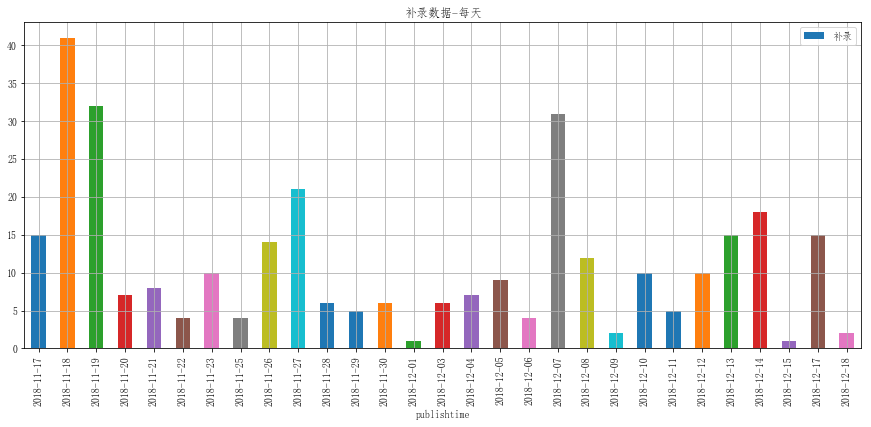

In [17]:
# 补录
apend = circ_cor_count[circ_cor_count['classify'] == '补录'][['publishtime', 'count']]
apend.columns = ['publishtime', '补录']
apend = apend.sort_values(by = 'publishtime', ascending = True)
apend.plot(kind = 'bar', x = 'publishtime', y = '补录', figsize=(15,6), 
           title = '补录数据-每天', grid = True)
apend.sort_values(by = 'publishtime', ascending = False).head()

### class

In [18]:
class_count = pd.concat([circ_cor_count, circ_uncor_count])
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2018-12-18    65.000  189.000   78.000  4908.000   88.000  299.000  349.000   
2018-12-17   859.000 4738.000 1258.000 75993.000 1983.000 3978.000 3020.000   
2018-12-16   266.000  785.000  771.000 40162.000 1224.000 1018.000 1111.000   
2018-12-15   679.000 1123.000  890.000 52635.000 1600.000 1607.000  847.000   
2018-12-14  1507.000 4549.000 1812.000 77934.000 7186.000 4113.000 2502.000   

                                    总量       非噪音 非噪音-比例 噪音-比例  
classify        补录     资本市场                                    
publishtime                                                    
2018-12-18   2.000  370.000   6348.000  1440.000  0.227 0.773  
2018-12-17  15.000 4942.000  96786.000 20793.000  0.215 0.785  
2018-12-16     nan 1523.000  46860.000  6698.000  0.143 0.857  
2018-12-15   1.000 1335.000  60717.000  8082.000  0.133 0.867  
2018-12-14  18.000 4260.000 103881.000 25947.000  0.250 0.750

count                                                         \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务       监管       行业   
publishtime                                                                   
2018-12-18    65.000  189.000   78.000  4908.000   88.000  299.000  349.000   
2018-12-17   859.000 4738.000 1258.000 75993.000 1983.000 3978.000 3020.000   
2018-12-16   266.000  785.000  771.000 40162.000 1224.000 1018.000 1111.000   
2018-12-15   679.000 1123.000  890.000 52635.000 1600.000 1607.000  847.000   
2018-12-14  1507.000 4549.000 1812.000 77934.000 7186.000 4113.000 2502.000   

                                    总量  rate                                  \
classify        补录     资本市场             产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管   
publishtime                                                                    
2018-12-18   2.000  370.000   6348.000 0.010  0.030  0.012 0.773 0.014 0.047   
2018-12-17  15.000 4942.000  96786.000 0.009  0.049  0.013 0.785 0.020 0.041   
2018-12-16     nan 1523.000  46860.000 0.006  0.017  0.016 0.857 0.026 0.022   
2018-12-15   1.000 1335.000  60717.000 0.011  0.018  0.015 0.867 0.026 0.026   
2018-12-14  18.000 4260.000 103881.000 0.015  0.044  0.017 0.750 0.069 0.040   

                               
classify       行业    补录  资本市场  
publishtime                    
2018-12-18  0.055 0.000 0.058  
2018-12-17  0.031 0.000 0.051  
2018-12-16  0.024   nan 0.033  
2018-12-15  0.014 0.000 0.022  
2018-12-14  0.024 0.000 0.041

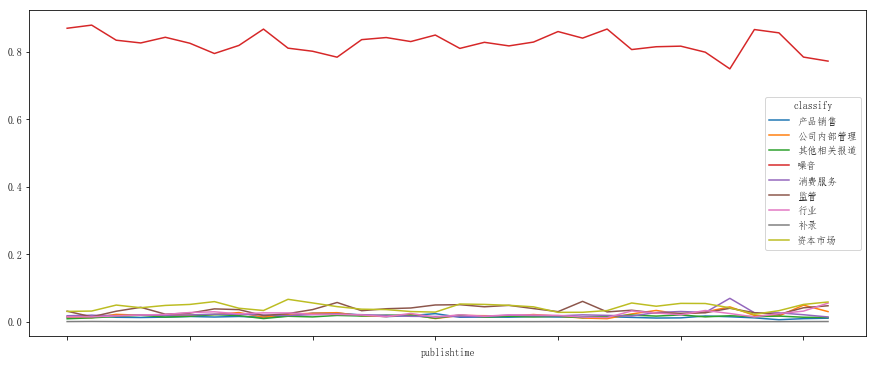

In [19]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

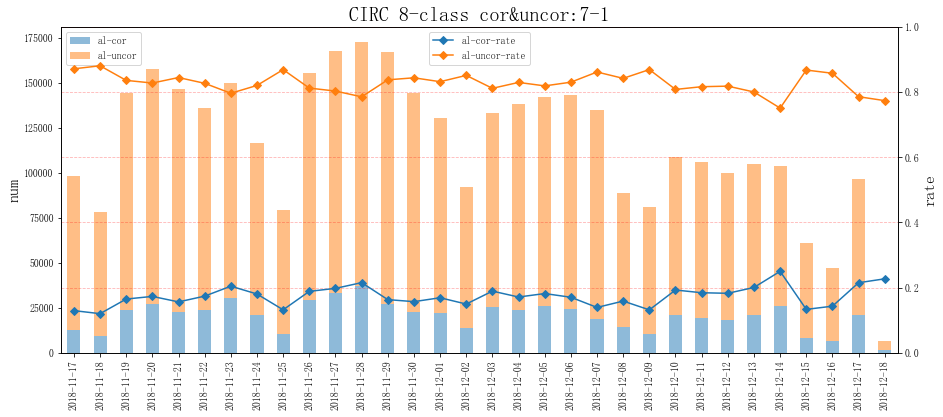

   publishtime        sum    al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2018-12-18   6348.000  1440.000  4908.000        0.227          0.773
30  2018-12-17  96786.000 20793.000 75993.000        0.215          0.785
29  2018-12-16  46860.000  6698.000 40162.000        0.143          0.857
28  2018-12-15  60717.000  8082.000 52635.000        0.133          0.867
27  2018-12-14 103881.000 25947.000 77934.000        0.250          0.750


In [20]:
plot_cor(count_data_7, circ_day_thing, "CIRC 8-class cor&uncor:7-1")

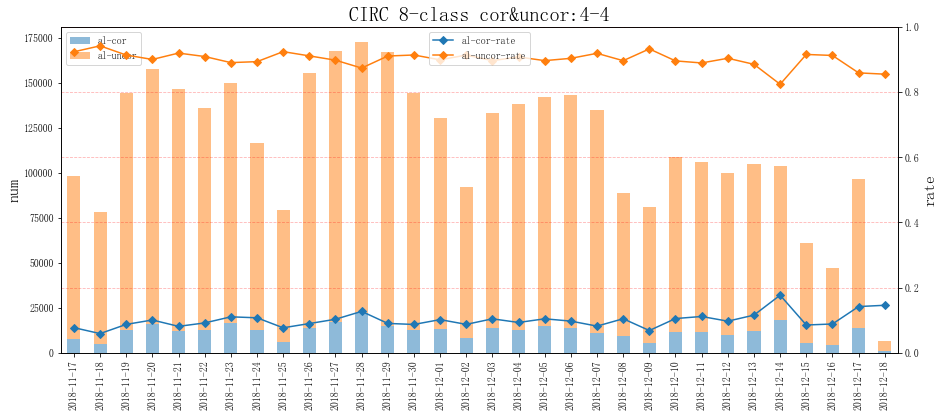

   publishtime    al_cor        sum  al_uncor  al_cor_rate  al_uncor_rate
31  2018-12-18   925.000   6348.000  5423.000        0.146          0.854
30  2018-12-17 13719.000  96786.000 83067.000        0.142          0.858
29  2018-12-16  4138.000  46860.000 42722.000        0.088          0.912
28  2018-12-15  5177.000  60717.000 55540.000        0.085          0.915
27  2018-12-14 18350.000 103881.000 85531.000        0.177          0.823


In [21]:
plot_cor(count_data_4, circ_day_thing, "CIRC 8-class cor&uncor:4-4")

## 倾向性

In [22]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.tendency, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count.head()

,publishtime,tendency,count
0,2018-12-18,-1,426
1,2018-12-18,0,1180
2,2018-12-17,-1,2649
3,2018-12-17,0,18195
4,2018-12-17,1,6


In [30]:
tend_count[~tend_count['tendency'].isin([-1, 0])].head()

,publishtime,tendency,count
4,2018-12-17,1,6
11,2018-12-14,1,6
14,2018-12-13,1,10
17,2018-12-12,1,5
22,2018-12-10,1,3


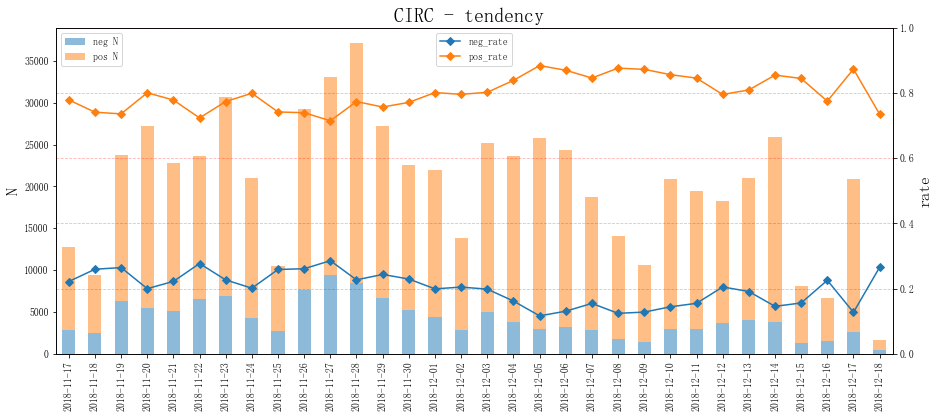

   publishtime   neg    pos    sum  neg_rate  pos_rate
31  2018-12-18   426   1180   1606     0.265     0.735
30  2018-12-17  2649  18195  20844     0.127     0.873
29  2018-12-16  1510   5189   6699     0.225     0.775
28  2018-12-15  1260   6826   8086     0.156     0.844
27  2018-12-14  3776  22165  25941     0.146     0.854


In [31]:
tend_count = tend_count[tend_count['tendency'].isin([-1, 0])]
plot_tend(tend_count, circ_day_thing, "CIRC - tendency ")

### group_id

In [ ]:
# sql_tend_group = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
#                             t1.tendency, t1.group_id, count(t1.id) as cor_count \
#                             from wise_web_docinfo t1 \
#                                 where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
#                                       date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
#                                 group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency, t1.group_id \
#                                 order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

# tend_group_count = pd.read_sql(sql_tend_group, engine)
# tend_group_count['group_id'] = tend_group_count['group_id'].apply(lambda x: group_dict[str(x)])
# tend_group_count.head()

## 补录和预警

### 一周数据

In [35]:
# add_start_day = '2018-10-27'
# add_end_day = '2018-11-02'

add_start_day = (today - datetime.timedelta(days=8)).strftime("%Y-%m-%d")
add_end_day = (today - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
print('add_start_day：',add_start_day)
print('add_end_day：',add_end_day)

add_start_day： 2018-12-10
add_end_day： 2018-12-17


In [36]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(74, 7)


In [37]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format(add_start_day, add_end_day) 

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(70, 7)


In [38]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['submited'].replace(0, '不预警').replace(1, '预警')

去重前 (144, 7)
去重后 (130, 7)


In [39]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_i"
url = "http://47.93.77.19:10000/judge_correlation_i"
parse_data, elapsed_time = get_server_res(data, url)
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,12692102,行业,,1,1
1,12695738,公司内部管理,,0,1
2,12698957,噪音,,0,0
3,12699666,公司内部管理,,0,1
4,12710146,公司内部管理,,0,1


In [40]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [41]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [42]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_cor, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_w_cor, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat

来源,微信,新闻,新闻客户端,视频,纸媒,总量
保监会：2018-12-10 到 2018-12-17,,,,,,
补录,5.000,65.000,3.000,1.000,NaN,74.000
预警数量,4.000,34.000,1.000,1.000,30.000,70.000
补录且预警,4.000,8.000,1.000,1.000,NaN,14.000
补录&过算法(7类),5.000,34.000,3.000,1.000,NaN,43.000
补录且预警&过算法(7类),4.000,6.000,1.000,1.000,NaN,12.000
补录且预警 / 预警-比例,100%,24%,100%,100%,nan%,20%
补录且预警 / 补录-比例,80%,12%,33%,100%,nan%,19%
补录&过算法(7类) / 补录-比例,100%,52%,100%,100%,nan%,58%
补录且预警&过算法(7类) / 补录且预警-比例,100%,75%,100%,100%,nan%,86%


### 导出一段时间补录数据用于训练

In [ ]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [ ]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [ ]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_i"
    url = "http://47.93.77.19:10000/judge_correlation_i"
    folder = 'circ_result_class'
    filename = 'circ_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'circ')

# 银行业--旧
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：

## 特殊时间点

In [43]:
engine = specific_func.get_engine('cbrc')

In [44]:
cbrc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

## 八分类

In [45]:
sql_cbrc = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
                        t2.traffic_id as classify, count(t1.id) as count \
                            from wise_web_docinfo_basic t1, wise_web_classify_traffic_docinfo t2 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t2.base_id=t1.id \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t2.traffic_id \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

cbrc_count = pd.read_sql(sql_cbrc, engine)
cbrc_count['classify'] = cbrc_count['classify'].apply(lambda x:class_name_dict[x])
cbrc_count.head()

,publishtime,classify,count
0,2018-12-18,监管,1001
1,2018-12-18,行业,2255
2,2018-12-18,产品销售,219
3,2018-12-18,资本市场,2956
4,2018-12-18,公司内部管理,377


### class

In [46]:
class_count = cbrc_count
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                      总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音  消费服务    监管     行业   资本市场           
publishtime                                                                 
2018-12-18    219    377    390   11100   795  1001   2255   2956   19093   
2018-12-17   2140   3922   3801  100385  9680  7485  15072  24493  166978   
2018-12-16   1157   1168   1402   54180  4075  2050   6380   8090   78502   
2018-12-15   1690   2291   3785   62950  5457  4465   8366   9636   98640   
2018-12-14   3077   4387   4840  102292  9883  7624  18132  19684  169919   

               非噪音 非噪音-比例 噪音-比例  
classify                         
publishtime                      
2018-12-18    7993  0.419 0.581  
2018-12-17   66593  0.399 0.601  
2018-12-16   24322  0.310 0.690  
2018-12-15   35690  0.362 0.638  
2018-12-14   67627  0.398 0.602

count                                                      总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音  消费服务    监管     行业   资本市场           
publishtime                                                                 
2018-12-18    219    377    390   11100   795  1001   2255   2956   19093   
2018-12-17   2140   3922   3801  100385  9680  7485  15072  24493  166978   
2018-12-16   1157   1168   1402   54180  4075  2050   6380   8090   78502   
2018-12-15   1690   2291   3785   62950  5457  4465   8366   9636   98640   
2018-12-14   3077   4387   4840  102292  9883  7624  18132  19684  169919   

             rate                                              
classify     产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                    
2018-12-18  0.011  0.020  0.020 0.581 0.042 0.052 0.118 0.155  
2018-12-17  0.013  0.023  0.023 0.601 0.058 0.045 0.090 0.147  
2018-12-16  0.015  0.015  0.018 0.690 0.052 0.026 0.081 0.103  
2018-12-15  0.017  0.023  0.038 0.638 0.055 0.045 0.085 0.098  
2018-12-14  0.018  0.026  0.028 0.602 0.058 0.045 0.107 0.116

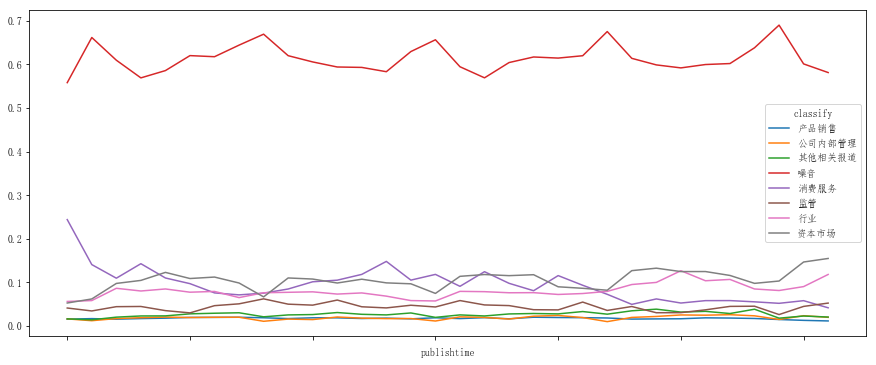

In [47]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

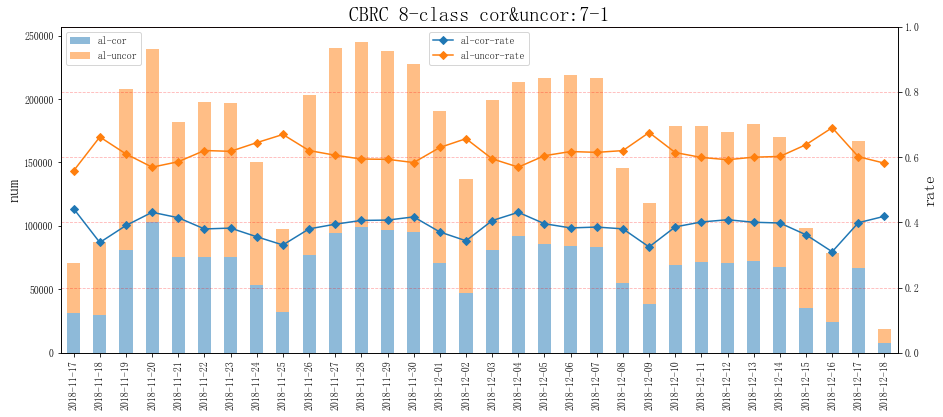

   publishtime     sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2018-12-18   19093    7993     11100        0.419          0.581
30  2018-12-17  166978   66593    100385        0.399          0.601
29  2018-12-16   78502   24322     54180        0.310          0.690
28  2018-12-15   98640   35690     62950        0.362          0.638
27  2018-12-14  169919   67627    102292        0.398          0.602


In [48]:
plot_cor(count_data_7, cbrc_day_thing, "CBRC 8-class cor&uncor:7-1")

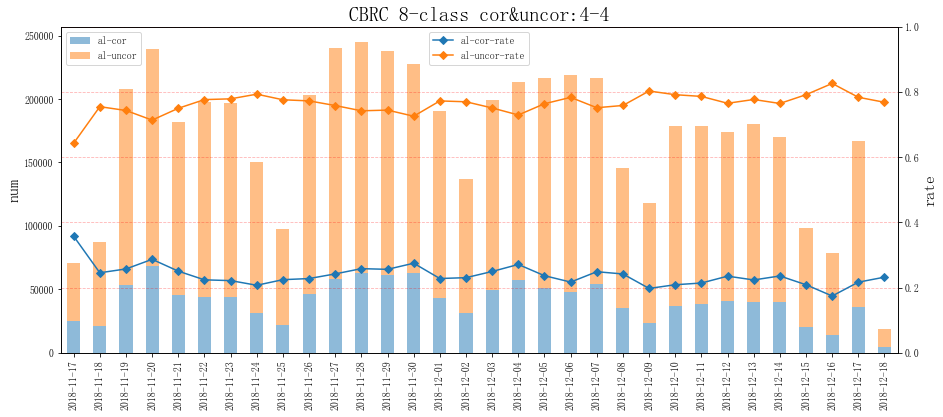

   publishtime  al_cor     sum  al_uncor  al_cor_rate  al_uncor_rate
31  2018-12-18    4428   19093     14665        0.232          0.768
30  2018-12-17   36159  166978    130819        0.217          0.783
29  2018-12-16   13673   78502     64829        0.174          0.826
28  2018-12-15   20579   98640     78061        0.209          0.791
27  2018-12-14   40026  169919    129893        0.236          0.764


In [49]:
plot_cor(count_data_4, cbrc_day_thing, "CBRC 8-class cor&uncor:4-4")

## 倾向性

In [50]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.sen as tendency, count(t1.id) as cor_count \
                            from elint_web_docinfo t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.sen \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count = tend_count[tend_count['tendency'] != 1]
tend_count.head()

,publishtime,tendency,cor_count
0,2018-12-18,-1,1385
1,2018-12-18,0,3365
3,2018-12-17,-1,12277
4,2018-12-17,0,24667
6,2018-12-16,-1,4487


In [51]:
tend_count[tend_count['tendency'].isin([-1, 0])].head()

,publishtime,tendency,cor_count
0,2018-12-18,-1,1385
1,2018-12-18,0,3365
3,2018-12-17,-1,12277
4,2018-12-17,0,24667
6,2018-12-16,-1,4487


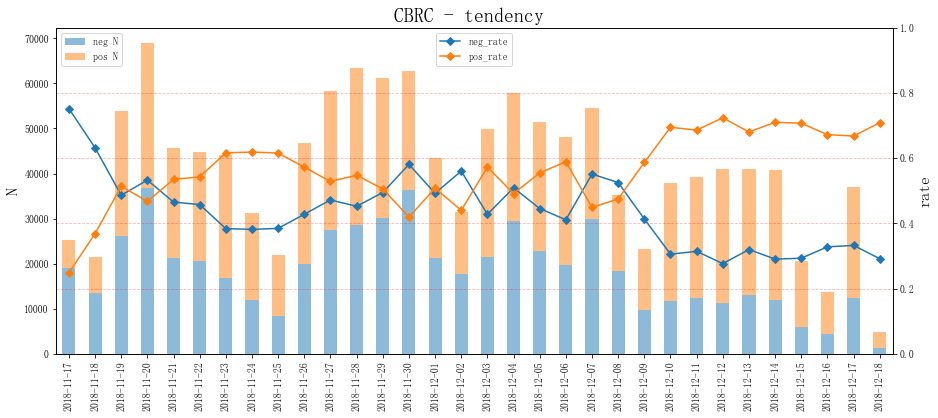

   publishtime    neg    pos    sum  neg_rate  pos_rate
31  2018-12-18   1385   3365   4750     0.292     0.708
30  2018-12-17  12277  24667  36944     0.332     0.668
29  2018-12-16   4487   9192  13679     0.328     0.672
28  2018-12-15   6030  14550  20580     0.293     0.707
27  2018-12-14  11829  28913  40742     0.290     0.710


In [52]:
tend_count = tend_count[tend_count['tendency'].isin([-1, 0])]
plot_tend(tend_count, cbrc_day_thing, "CBRC - tendency ")

## 补录和预警

### 补录数据

In [53]:
sql_human_additional = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, count(t1.id) as count \
                            from elint_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.gather_type = 1 \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

human_additional_count = pd.read_sql(sql_human_additional, engine)
human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

,publishtime,gather_type,count
0,2018-12-18,1,5
1,2018-12-17,1,51
2,2018-12-16,1,1
3,2018-12-14,1,35
4,2018-12-13,1,73


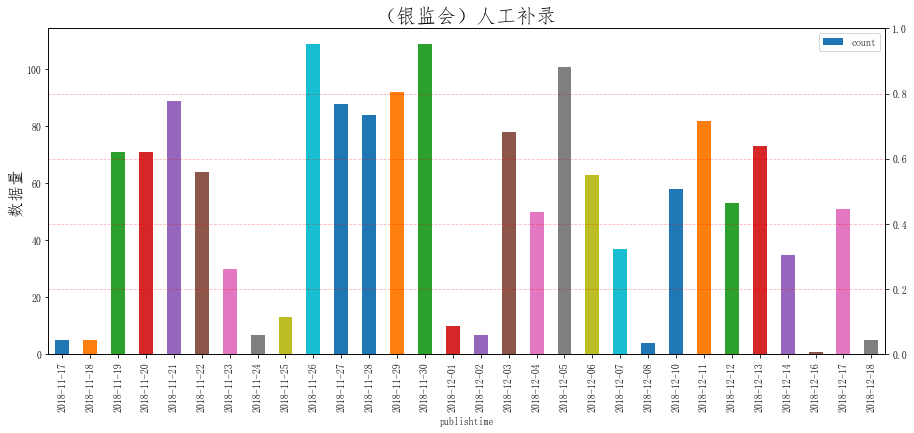

,publishtime,gather_type,count
0,2018-12-18,1,5
1,2018-12-17,1,51
2,2018-12-16,1,1
3,2018-12-14,1,35
4,2018-12-13,1,73


In [54]:
human_additional_count = human_additional_count.sort_values(by = 'publishtime')
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
human_additional_count.plot(x = 'publishtime', y = 'count', kind = 'bar', figsize = (15, 6), ax = ax1)
ax1.set_ylabel('数据量', fontsize = 16)
ax1.set_title("（银监会）人工补录", fontsize = 20)

ax2 = ax1.twinx()  # this is the important function
ax2.set_ylim(0, 1)
y_list = [0.65, 0.75, 0.85, 0.95]
m = 0
for [d, t] in cbrc_day_thing:    
    if d in human_additional_count['publishtime'].tolist():
        x = human_additional_count['publishtime'].tolist().index(d)
        ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                    color='k', linestyle = "--", alpha = 0.75)
        ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
        if m == 3: 
            m = 0
        else :
            m += 1
        
plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
plt.show()

human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

### 一周数据

In [57]:
# add_start_day = '2018-10-27'
# add_end_day = '2018-11-02'

add_start_day = (today - datetime.timedelta(days=8)).strftime("%Y-%m-%d")
add_end_day = (today - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
print('add_start_day：',add_start_day)
print('add_end_day：',add_end_day)

add_start_day： 2018-12-10
add_end_day： 2018-12-17


In [58]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(353, 7)


In [59]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format(add_start_day, add_end_day)  

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(761, 7)


In [60]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(0, '系统采集').replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['sec'].apply(lambda x: '预警' if x in [7,8,9] else '不预警')
# combined_data.head()

去重前 (1114, 7)
去重后 (771, 7)


In [61]:
combined_data.groupby(['gather_type', 'group_id', 'submited'])['id'].count()

gather_type  group_id  submited
4            微博        预警          248
人工修改         外媒        预警            1
             微博        预警            7
             新闻        预警           80
             新闻客户端     预警            1
             纸媒        预警           76
             论坛        预警            5
人工补录         微博        预警          319
             新闻        不预警          10
                       预警           20
             纸媒        预警            1
             论坛        预警            3
Name: id, dtype: int64

In [62]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_yjh"
url = "http://47.93.77.19:6001/judge_correlation_yjh"
parse_data = get_server_res_yjh(data, url, 'sec')
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,272755961,资本市场,,0,1
1,272759722,噪音,,0,0
2,272766705,消费服务,,1,1
3,272766784,消费服务,,1,1
4,272766835,消费服务,,1,1


In [63]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [64]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [65]:
stat

,group_id,gather_type,submited,id
0,外媒,人工修改,预警,1
1,微博,4,预警,248
2,微博,人工修改,预警,7
3,微博,人工补录,预警,319
4,新闻,人工修改,预警,80
5,新闻,人工补录,不预警,10
6,新闻,人工补录,预警,20
7,新闻客户端,人工修改,预警,1
8,纸媒,人工修改,预警,76
9,纸媒,人工补录,预警,1


In [67]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor, on = '来源')
stat = pd.merge(stat, stat_a_w_cor, on = '来源')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat = stat.fillna(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
# stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
# stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat.fillna(0)

来源,微博,新闻,纸媒,论坛,总量
保监会：2018-12-10 到 2018-12-17,,,,,
补录,319.000,30.000,1.000,3.000,353.000
预警数量,574.000,100.000,77.000,8.000,759.000
补录且预警,319.000,20.000,1.000,3.000,343.000
补录&过算法(4类),286.000,9.000,1.000,2.000,298.000
补录且预警&过算法(4类),286.000,8.000,1.000,2.000,297.000
补录&过算法(7类),298.000,22.000,1.000,2.000,323.000
补录且预警&过算法(7类),298.000,18.000,1.000,2.000,319.000
补录且预警 / 预警-比例,56%,20%,1%,38%,45%
补录&过算法(4类) / 补录-比例,90%,30%,100%,67%,84%


### 导出一段时间补录数据用于训练

In [ ]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [ ]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [ ]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_yjh"
    url = "http://47.93.77.19:6001/judge_correlation_yjh"
    folder = 'cbrc_result_class'
    filename = 'cbrc_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'cbrc')

# 安徽银监局
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：
- 20191219
  - 八分类：
  - 倾向性：
  - 补录：

## 特殊时间点

In [179]:
engine = specific_func.get_engine('ahyjj')

In [180]:
cbirc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

In [181]:
start_day = today - datetime.timedelta(days=32) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

# day_select = '2018-09-09'
day_list = get_day_list(start_day, end_day)
print(day_list)
len(day_list)

start_day： 2018-11-17
end_day： 2018-12-18
['2018-11-18', '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22', '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26', '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30', '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04', '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08', '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14', '2018-12-15', '2018-12-16', '2018-12-17', '2018-12-18']


31

## 获取数据

In [183]:
for t in range(6, 7):
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            print('   已存在：', filename)
        else :
            t0 = time.time()
            sql_cbirc = '''
            SELECT
                t2.type,
                t1.traffic_id AS classify,
                t2.sen as tendency, 
                COUNT(t1.id) AS count,
                t2.gather_type,
                t3.group_id,
                t2.sec
            FROM
                cbrc_circ.db_classify_traffic_docinfo t1
                    LEFT JOIN
                cbrc_circ.db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
                    LEFT JOIN
                cbrc_circ.db_docinfo t3 ON t2.urlhash = t3.urlhash
            WHERE
                t3.publishtime >= '{0} 00:00:00'
                AND t3.publishtime <= '{0} 23:59:59'
                    and t2.type = {1}
                    and t1.type = t2.type
            GROUP BY t2.gather_type, t2.type , t1.traffic_id, t3.group_id, t2.sen, t2.sec
            '''.format(day, 1)

            cbirc_count_type = pd.read_sql(sql_cbirc, engine)     
            cbirc_count_type['publishtime'] = day
            cbirc_count_type.to_excel(filename, index = False)    
            print('   日期：%s ；耗时：%s s'%(day, time.time() - t0))
            print('   已生成：', filename)

获取 安徽银监局 的数据 -------
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-18_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-19_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-20_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-21_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-22_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-23_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-24_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-25_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-26_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-27_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/安徽银监局_2018-11-28_mysql

In [184]:
cbirc_count_all = pd.DataFrame()
for t in range(6, 7):
#     print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            cbirc_count_type = pd.read_excel(filename)
            cbirc_count_all = pd.concat([cbirc_count_all, cbirc_count_type], axis = 0)
        else :
            print('   不存在：', filename)

In [185]:
# cbirc_count_all.rename(columns={'publistime': 'publishtime'}, inplace=True) 
print(cbirc_count_all.shape)
cbirc_count_all.head()

(2522, 8)


,type,classify,tendency,count,gather_type,group_id,sec,publishtime
0,1,1,-1,15,0,1,4,2018-11-18
1,1,1,0,501,0,1,4,2018-11-18
2,1,1,-1,7,0,2,4,2018-11-18
3,1,1,0,2,0,3,4,2018-11-18
4,1,1,-1,17,0,4,4,2018-11-18


### 八分类数据

In [186]:
cbirc_count = cbirc_count_all.groupby(['publishtime', 'type', 'classify'])['count'].sum()
cbirc_count = cbirc_count.reset_index(['publishtime', 'type', 'classify'])
cbirc_count.head()

,publishtime,type,classify,count
0,2018-11-18,1,1,751
1,2018-11-18,1,2,1349
2,2018-11-18,1,3,1042
3,2018-11-18,1,4,1818
4,2018-11-18,1,5,510


In [187]:
cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[int(x)])
cbirc_count['type'] = cbirc_count['type'].apply(lambda x:proj_name_dict[int(6)])
print(cbirc_count.shape)
print(cbirc_count.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_count['count'].sum())
cbirc_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(248, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 4 columns):
publishtime    248 non-null object
type           248 non-null object
classify       248 non-null object
count          248 non-null int64
dtypes: int64(1), object(3)
memory usage: 69.0 KB
None
1938548


sum         
               count         
type           安徽银监局      All
publishtime                  
2018-11-18     33085    33085
2018-11-19     63678    63678
2018-11-20     74873    74873
2018-11-21     67542    67542
2018-11-22     64245    64245
2018-11-23     64123    64123
2018-11-24     49106    49106
2018-11-25     32304    32304
2018-11-26     74278    74278
2018-11-27     77266    77266
2018-11-28     89244    89244
2018-11-29     91323    91323
2018-11-30     76514    76514
2018-12-01     59985    59985
2018-12-02     40556    40556
2018-12-03     67049    67049
2018-12-04     70891    70891
2018-12-05     71467    71467
2018-12-06     74562    74562
2018-12-07     77952    77952
2018-12-08     45733    45733
2018-12-09     41982    41982
2018-12-10     67444    67444
2018-12-11     67409    67409
2018-12-12     73701    73701
2018-12-13     76652    76652
2018-12-14     70538    70538
2018-12-15     36105    36105
2018-12-16     24718    24718
2018-12-17     57085    57085
2018-12-18     57138    57138
All          1938548  1938548

### 倾向性数据

In [188]:
tend_count = cbirc_count_all.groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count = tend_count.reset_index(['publishtime', 'type', 'tendency'])
tend_count.head()

,publishtime,type,tendency,count
0,2018-11-18,1,-1,1056
1,2018-11-18,1,0,32029
2,2018-11-19,1,-1,2141
3,2018-11-19,1,0,61537
4,2018-11-20,1,-1,2987


In [189]:
# cor_list = ['产品销售', '资本市场', '其他相关报道', '噪音'] # 3、4、7、8
cor_list = [3,4,7,8]
tend_count_4 = cbirc_count_all[~cbirc_count_all['classify'].isin(cor_list)].groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count_4 = tend_count_4.reset_index(['publishtime', 'type', 'tendency'])
tend_count_4['type'] = tend_count_4['type'].apply(lambda x:proj_name_dict[int(6)])
tend_count_4.head()

,publishtime,type,tendency,count
0,2018-11-18,安徽银监局,-1,1056
1,2018-11-18,安徽银监局,0,2535
2,2018-11-19,安徽银监局,-1,2139
3,2018-11-19,安徽银监局,0,7373
4,2018-11-20,安徽银监局,-1,2986


In [190]:
tend_count['type'] = tend_count['type'].apply(lambda x:proj_name_dict[int(6)])
print(tend_count.shape)
print(tend_count.info(memory_usage = 'deep'))
# tend_count.head()

print(tend_count['count'].sum())
tend_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(62, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 4 columns):
publishtime    62 non-null object
type           62 non-null object
tendency       62 non-null int64
count          62 non-null int64
dtypes: int64(2), object(2)
memory usage: 11.6 KB
None
1938548


sum         
               count         
type           安徽银监局      All
publishtime                  
2018-11-18     33085    33085
2018-11-19     63678    63678
2018-11-20     74873    74873
2018-11-21     67542    67542
2018-11-22     64245    64245
2018-11-23     64123    64123
2018-11-24     49106    49106
2018-11-25     32304    32304
2018-11-26     74278    74278
2018-11-27     77266    77266
2018-11-28     89244    89244
2018-11-29     91323    91323
2018-11-30     76514    76514
2018-12-01     59985    59985
2018-12-02     40556    40556
2018-12-03     67049    67049
2018-12-04     70891    70891
2018-12-05     71467    71467
2018-12-06     74562    74562
2018-12-07     77952    77952
2018-12-08     45733    45733
2018-12-09     41982    41982
2018-12-10     67444    67444
2018-12-11     67409    67409
2018-12-12     73701    73701
2018-12-13     76652    76652
2018-12-14     70538    70538
2018-12-15     36105    36105
2018-12-16     24718    24718
2018-12-17     57085    57085
2018-12-18     57138    57138
All          1938548  1938548

### 预警与补录数据

In [191]:
cbirc_add = cbirc_count_all.groupby(['publishtime', 'type', 'gather_type'])['count'].sum()
cbirc_add = cbirc_add.reset_index(['publishtime', 'type', 'gather_type'])
cbirc_add = cbirc_add[cbirc_add['gather_type'].isin([1,3])]
cbirc_add.head()

,publishtime,type,gather_type,count
2,2018-11-19,1,1,3
4,2018-11-20,1,1,1
6,2018-11-21,1,1,1
13,2018-11-27,1,1,1


In [192]:
# cbirc_add['gather_type'] = cbirc_add['gather_type'].apply(lambda x:group_dict[str(x)])
cbirc_add['type'] = cbirc_add['type'].apply(lambda x:proj_name_dict[int(6)])
print(cbirc_add.shape)
print(cbirc_add.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_add['count'].sum())
cbirc_add.pivot_table(index = ['publishtime'], columns = ['type', 'gather_type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(4, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 2 to 13
Data columns (total 4 columns):
publishtime    4 non-null object
type           4 non-null object
gather_type    4 non-null int64
count          4 non-null int64
dtypes: int64(2), object(2)
memory usage: 796.0 bytes
None
6


sum    
            count    
type        安徽银监局 All
gather_type     1    
publishtime          
2018-11-19      3   3
2018-11-20      1   1
2018-11-21      1   1
2018-11-27      1   1
All             6   6

## 八分类

In [65]:
class_count = cbirc_count[cbirc_count['type'] == '安徽银监局'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                  总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场                 
publishtime                                                                    
2018-12-18   1708   2847   3727  37157  1822  1207  2687  5902  57057  19900   
2018-12-17   1540   2560   2573  36497  1632  1860  3375  6937  56974  20477   
2018-12-16    710    776    832  17798   694   533  1330  2021  24694   6896   
2018-12-15   1116   1832   3053  23245   947   932  2127  2817  36069  12824   
2018-12-14   1760   3867   3684  44502  1881  2666  5090  7049  70499  25997   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-12-18   0.349 0.651  
2018-12-17   0.359 0.641  
2018-12-16   0.279 0.721  
2018-12-15   0.356 0.644  
2018-12-14   0.369 0.631

count                                                  总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场         产品销售   
publishtime                                                                   
2018-12-18   1708   2847   3727  37157  1822  1207  2687  5902  57057 0.030   
2018-12-17   1540   2560   2573  36497  1632  1860  3375  6937  56974 0.027   
2018-12-16    710    776    832  17798   694   533  1330  2021  24694 0.029   
2018-12-15   1116   1832   3053  23245   947   932  2127  2817  36069 0.031   
2018-12-14   1760   3867   3684  44502  1881  2666  5090  7049  70499 0.025   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-12-18   0.050  0.065 0.651 0.032 0.021 0.047 0.103  
2018-12-17   0.045  0.045 0.641 0.029 0.033 0.059 0.122  
2018-12-16   0.031  0.034 0.721 0.028 0.022 0.054 0.082  
2018-12-15   0.051  0.085 0.644 0.026 0.026 0.059 0.078  
2018-12-14   0.055  0.052 0.631 0.027 0.038 0.072 0.100

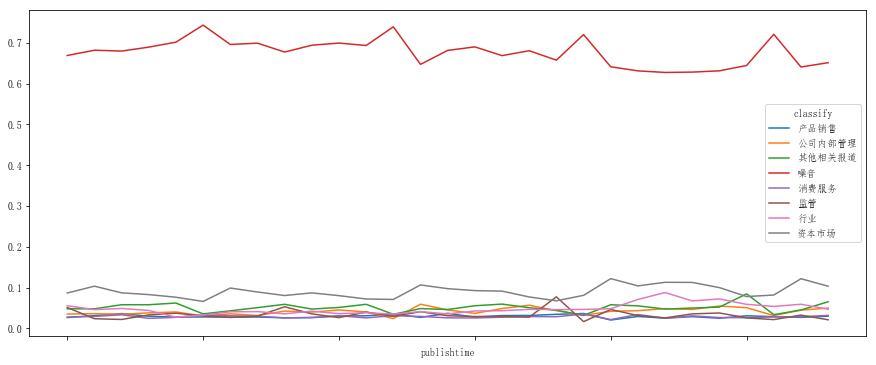

In [66]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

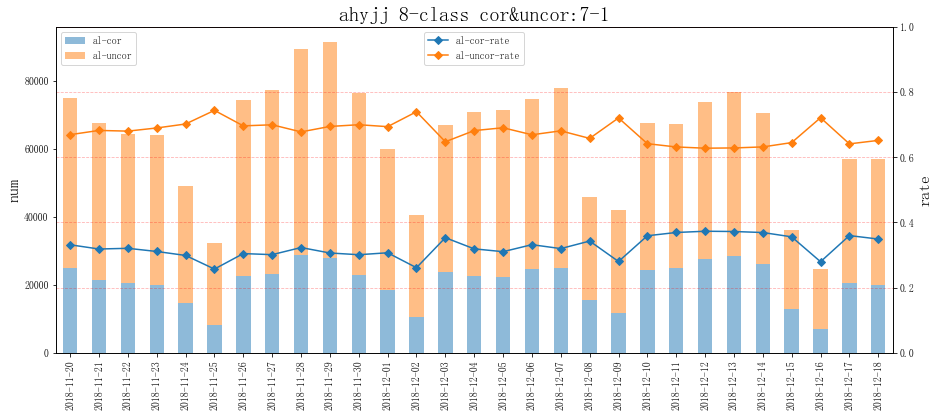

   publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-18  57057   19900     37157        0.349          0.651
27  2018-12-17  56974   20477     36497        0.359          0.641
26  2018-12-16  24694    6896     17798        0.279          0.721
25  2018-12-15  36069   12824     23245        0.356          0.644
24  2018-12-14  70499   25997     44502        0.369          0.631


In [67]:
plot_cor(count_data_7, cbirc_day_thing, "ahyjj 8-class cor&uncor:7-1")

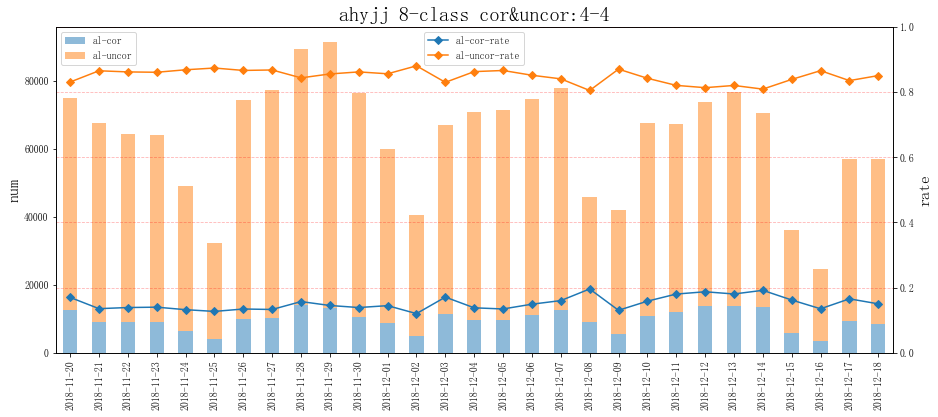

   publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-18    8563  57057     48494        0.150          0.850
27  2018-12-17    9427  56974     47547        0.165          0.835
26  2018-12-16    3333  24694     21361        0.135          0.865
25  2018-12-15    5838  36069     30231        0.162          0.838
24  2018-12-14   13504  70499     56995        0.192          0.808


In [68]:
plot_cor(count_data_4, cbirc_day_thing, "ahyjj 8-class cor&uncor:4-4")

## 倾向性

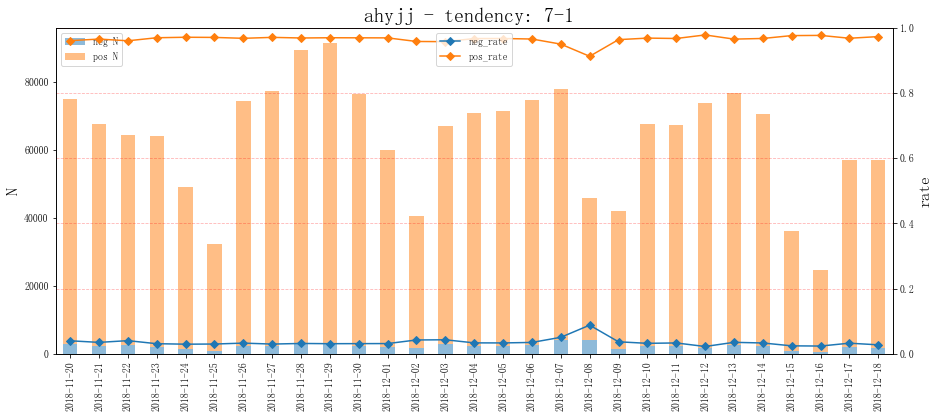

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2018-12-18  1568  55489  57057     0.027     0.973
27  2018-12-17  1854  55120  56974     0.033     0.967
26  2018-12-16   587  24107  24694     0.024     0.976
25  2018-12-15   880  35189  36069     0.024     0.976
24  2018-12-14  2341  68158  70499     0.033     0.967


In [75]:
plot_tend(tend_count[tend_count['type'] == '安徽银监局'].drop('type', axis = 1), cbirc_day_thing, "ahyjj - tendency: 7-1 ")

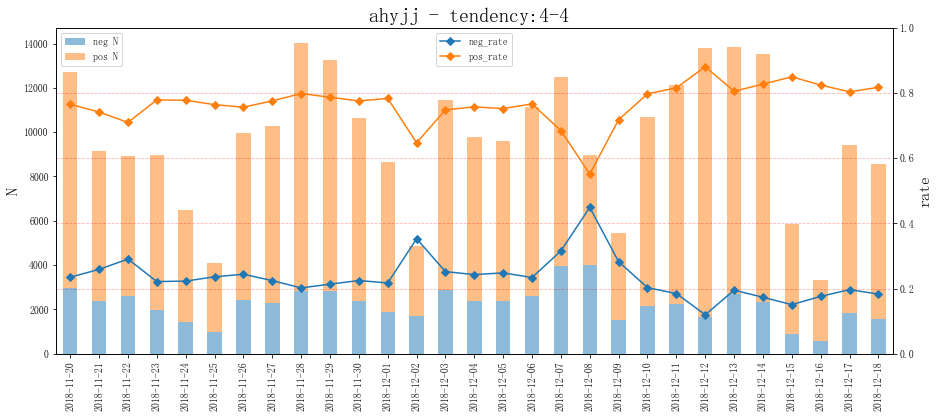

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2018-12-18  1568   6995   8563     0.183     0.817
27  2018-12-17  1854   7573   9427     0.197     0.803
26  2018-12-16   587   2746   3333     0.176     0.824
25  2018-12-15   880   4958   5838     0.151     0.849
24  2018-12-14  2341  11163  13504     0.173     0.827


In [79]:
plot_tend(tend_count_4[tend_count_4['type'] == '安徽银监局'].drop('type', axis = 1), cbirc_day_thing, "ahyjj - tendency:4-4 ")

## 补录

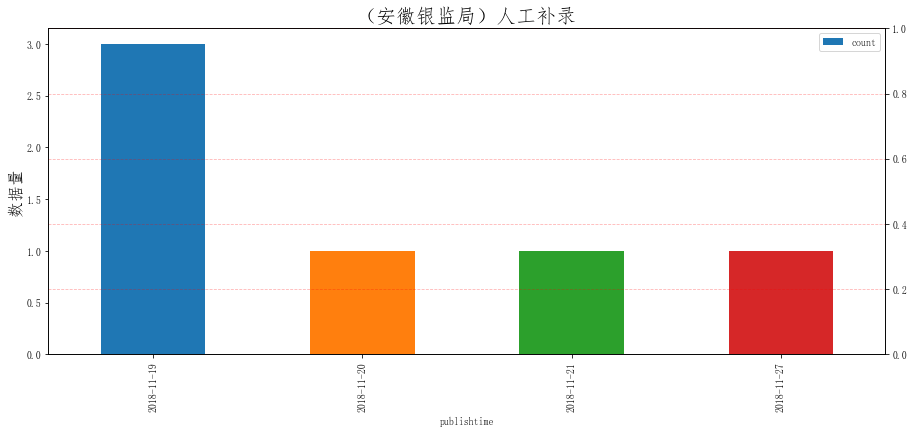

  publishtime  count
3  2018-11-27      1
2  2018-11-21      1
1  2018-11-20      1
0  2018-11-19      3


In [193]:
plot_add(cbirc_add[cbirc_add['type'] == '安徽银监局'], cbirc_day_thing, "（安徽银监局）人工补录")

# 银保监会--新

## 特殊时间点

In [13]:
engine = specific_func.get_engine('cbirc')

In [14]:
cbirc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

In [15]:
start_day = today - datetime.timedelta(days=30) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

# day_select = '2018-09-09'
day_list = get_day_list(start_day, end_day)
print(day_list)

start_day： 2018-11-19
end_day： 2018-12-18
['2018-11-20', '2018-11-21', '2018-11-22', '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26', '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30', '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04', '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08', '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14', '2018-12-15', '2018-12-16', '2018-12-17', '2018-12-18']


## 获取数据

In [16]:
for t in range(1, 6):
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            print('   已存在：', filename)
        else :
            t0 = time.time()
            sql_cbirc = '''
            SELECT
                t2.type,
                t1.traffic_id AS classify,
                t2.sen as tendency, 
                COUNT(t1.id) AS count,
                t2.gather_type,
                t3.group_id,
                t2.sec
            FROM
                cbrc_circ.db_classify_traffic_docinfo t1
                    LEFT JOIN
                cbrc_circ.db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
                    LEFT JOIN
                cbrc_circ.db_docinfo t3 ON t2.urlhash = t3.urlhash
            WHERE
                t3.publishtime >= '{0} 00:00:00'
                AND t3.publishtime <= '{0} 23:59:59'
                    and t2.type = {1}
                    and t1.type = t2.type
            GROUP BY t2.gather_type, t2.type , t1.traffic_id, t3.group_id, t2.sen, t2.sec
            '''.format(day, t)

            cbirc_count_type = pd.read_sql(sql_cbirc, engine)     
            cbirc_count_type['publishtime'] = day
            cbirc_count_type.to_excel(filename, index = False)    
            print('   日期：%s ；耗时：%s s'%(day, time.time() - t0))
            print('   已生成：', filename)

获取 银监会 的数据 -------
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-20_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-21_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-22_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-23_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-24_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-25_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-26_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-27_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-28_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-29_mysql_stat.xlsx
   已存在： statistics_result/mysql_daily_count_by_condition/银监会_2018-11-30_mysql_stat.xlsx
   已存在： stati

   日期：2018-11-30 ；耗时：63.40462636947632 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人寿_2018-11-30_mysql_stat.xlsx
   日期：2018-12-01 ；耗时：52.59500813484192 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人寿_2018-12-01_mysql_stat.xlsx
   日期：2018-12-02 ；耗时：37.58814978599548 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人寿_2018-12-02_mysql_stat.xlsx
   日期：2018-12-03 ；耗时：70.77404808998108 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人寿_2018-12-03_mysql_stat.xlsx
   日期：2018-12-04 ；耗时：71.87311100959778 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人寿_2018-12-04_mysql_stat.xlsx
   日期：2018-12-05 ；耗时：52.68401336669922 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人寿_2018-12-05_mysql_stat.xlsx
   日期：2018-12-06 ；耗时：47.299705266952515 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人寿_2018-12-06_mysql_stat.xlsx
   日期：2018-12-07 ；耗时：46.71667194366455 s
   已生成： statistics_result/mysql_daily_count_by_c

   日期：2018-12-05 ；耗时：61.58952307701111 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人保_2018-12-05_mysql_stat.xlsx
   日期：2018-12-06 ；耗时：60.01643252372742 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人保_2018-12-06_mysql_stat.xlsx
   日期：2018-12-07 ；耗时：56.082207679748535 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人保_2018-12-07_mysql_stat.xlsx
   日期：2018-12-08 ；耗时：42.97845816612244 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人保_2018-12-08_mysql_stat.xlsx
   日期：2018-12-09 ；耗时：41.49837350845337 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人保_2018-12-09_mysql_stat.xlsx
   日期：2018-12-10 ；耗时：78.47648882865906 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人保_2018-12-10_mysql_stat.xlsx
   日期：2018-12-11 ；耗时：62.33256506919861 s
   已生成： statistics_result/mysql_daily_count_by_condition/中国人保_2018-12-11_mysql_stat.xlsx
   日期：2018-12-12 ；耗时：56.834250926971436 s
   已生成： statistics_result/mysql_daily_count_by_

In [80]:
cbirc_count_all = pd.DataFrame()
for t in range(1, 6):
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    for day in day_list:
        filename = 'statistics_result/mysql_daily_count_by_condition/%s_%s_mysql_stat.xlsx'%(proj_name_dict[t], day)
        if os.path.exists(filename):
            cbirc_count_type = pd.read_excel(filename)
            cbirc_count_all = pd.concat([cbirc_count_all, cbirc_count_type], axis = 0)
        else :
            print('   不存在：', filename)

获取 银监会 的数据 -------
获取 保监会 的数据 -------
获取 中国人寿 的数据 -------
获取 建行北分 的数据 -------
获取 中国人保 的数据 -------


In [81]:
print(cbirc_count_all.shape)
cbirc_count_all.head()

(10903, 8)


,type,classify,tendency,count,gather_type,group_id,sec,publishtime
0,1,1,-1,148,0,1,4,2018-11-20
1,1,1,0,2676,0,1,4,2018-11-20
2,1,1,-1,1,0,2,4,2018-11-20
3,1,1,-1,1,0,3,4,2018-11-20
4,1,1,0,9,0,3,4,2018-11-20


### 八分类数据

In [82]:
cbirc_count = cbirc_count_all.groupby(['publishtime', 'type', 'classify'])['count'].sum()
cbirc_count = cbirc_count.reset_index(['publishtime', 'type', 'classify'])
cbirc_count.head()

,publishtime,type,classify,count
0,2018-11-20,1,1,3833
1,2018-11-20,1,2,4161
2,2018-11-20,1,3,1991
3,2018-11-20,1,4,6495
4,2018-11-20,1,5,2641


In [83]:
cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[int(x)])
cbirc_count['type'] = cbirc_count['type'].apply(lambda x:proj_name_dict[int(x)])
print(cbirc_count.shape)
print(cbirc_count.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_count['count'].sum())
cbirc_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(1218, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 4 columns):
publishtime    1218 non-null object
type           1218 non-null object
classify       1218 non-null object
count          1218 non-null int64
dtypes: int64(1), object(3)
memory usage: 330.1 KB
None
4425988


sum                                           
              count                                           
type           中国人保    中国人寿      保监会    建行北分      银监会      All
publishtime                                                   
2018-11-20    87505    5307    70166   14342    74886   252206
2018-11-21    46077    4926    62504   12581    67551   193639
2018-11-22    19055    4741    62650   10852    64278   161576
2018-11-23    19451    4999    69553   13886    64123   172012
2018-11-24    13952    3283    55704    8646    49106   130691
2018-11-25     6827    2115    37732    5734    32304    84712
2018-11-26    26280    5266    74781   11862    74278   192467
2018-11-27    22368    6454    85542   15229    77266   206859
2018-11-28    16226    8352    90513   11223    89244   215558
2018-11-29    13514    7322    82200    7340    91323   201699
2018-11-30    14463    5959    68146    6134    76514   171216
2018-12-01    17386    5140    66171    1818    59985   150500
2018-12-02    11122    3442    46103    1003    40556   102226
2018-12-03     9997    5503    64910    1647    67049   149106
2018-12-04    12800    4840    66397    3008    70891   157936
2018-12-05    15651    5009    69653    1935    71467   163715
2018-12-06    14982    5255    69435    1650    74562   165884
2018-12-07    11796    3588    69972    2269    77952   165577
2018-12-08    13551    2113    42334    2489    45733   106220
2018-12-09    14927    1467    39247    1362    41982    98985
2018-12-10    23613    3067    52152    2523    67444   148799
2018-12-11    18922    3400    55011    1992    67409   146734
2018-12-12    13141    4664    57687    2032    73695   151219
2018-12-13    13861    5879    64195    2269    76649   162853
2018-12-14    15740    5233    63198    4782    70519   159472
2018-12-15    12144    1067    30775    2990    36086    83062
2018-12-16    15201     674    24445    1496    24706    66522
2018-12-17    15739    2677    57540    5673    57034   138663
2018-12-18    13408    3093    49150    3193    57036   125880
All          549699  124835  1747866  161960  1841628  4425988

### 倾向性数据

In [124]:
tend_count = cbirc_count_all.groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count = tend_count.reset_index(['publishtime', 'type', 'tendency'])
tend_count.head()

,publishtime,type,tendency,count
0,2018-11-20,1,-1,2987
1,2018-11-20,1,0,71899
2,2018-11-20,2,-1,2255
3,2018-11-20,2,0,67911
4,2018-11-20,3,-1,348


In [125]:
# cor_list = ['产品销售', '资本市场', '其他相关报道', '噪音'] # 3、4、7、8
cor_list = [3,4,7,8]
tend_count_4 = cbirc_count_all[~cbirc_count_all['classify'].isin(cor_list)].groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count_4 = tend_count_4.reset_index(['publishtime', 'type', 'tendency'])
tend_count_4['type'] = tend_count_4['type'].apply(lambda x:proj_name_dict[int(x)])
tend_count_4.head()

,publishtime,type,tendency,count
0,2018-11-20,银监会,-1,2986
1,2018-11-20,银监会,0,9730
2,2018-11-20,保监会,-1,2255
3,2018-11-20,保监会,0,6849
4,2018-11-20,中国人寿,-1,268


In [126]:
tend_count['type'] = tend_count['type'].apply(lambda x:proj_name_dict[int(x)])
print(tend_count.shape)
print(tend_count.info(memory_usage = 'deep'))
# tend_count.head()

print(tend_count['count'].sum())
tend_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(290, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 4 columns):
publishtime    290 non-null object
type           290 non-null object
tendency       290 non-null int64
count          290 non-null int64
dtypes: int64(2), object(2)
memory usage: 58.4 KB
None
4425988


sum                                           
              count                                           
type           中国人保    中国人寿      保监会    建行北分      银监会      All
publishtime                                                   
2018-11-20    87505    5307    70166   14342    74886   252206
2018-11-21    46077    4926    62504   12581    67551   193639
2018-11-22    19055    4741    62650   10852    64278   161576
2018-11-23    19451    4999    69553   13886    64123   172012
2018-11-24    13952    3283    55704    8646    49106   130691
2018-11-25     6827    2115    37732    5734    32304    84712
2018-11-26    26280    5266    74781   11862    74278   192467
2018-11-27    22368    6454    85542   15229    77266   206859
2018-11-28    16226    8352    90513   11223    89244   215558
2018-11-29    13514    7322    82200    7340    91323   201699
2018-11-30    14463    5959    68146    6134    76514   171216
2018-12-01    17386    5140    66171    1818    59985   150500
2018-12-02    11122    3442    46103    1003    40556   102226
2018-12-03     9997    5503    64910    1647    67049   149106
2018-12-04    12800    4840    66397    3008    70891   157936
2018-12-05    15651    5009    69653    1935    71467   163715
2018-12-06    14982    5255    69435    1650    74562   165884
2018-12-07    11796    3588    69972    2269    77952   165577
2018-12-08    13551    2113    42334    2489    45733   106220
2018-12-09    14927    1467    39247    1362    41982    98985
2018-12-10    23613    3067    52152    2523    67444   148799
2018-12-11    18922    3400    55011    1992    67409   146734
2018-12-12    13141    4664    57687    2032    73695   151219
2018-12-13    13861    5879    64195    2269    76649   162853
2018-12-14    15740    5233    63198    4782    70519   159472
2018-12-15    12144    1067    30775    2990    36086    83062
2018-12-16    15201     674    24445    1496    24706    66522
2018-12-17    15739    2677    57540    5673    57034   138663
2018-12-18    13408    3093    49150    3193    57036   125880
All          549699  124835  1747866  161960  1841628  4425988

### 补录数据

In [141]:
cbirc_add = cbirc_count_all.groupby(['publishtime', 'type', 'gather_type'])['count'].sum()
cbirc_add = cbirc_add.reset_index(['publishtime', 'type', 'gather_type'])
cbirc_add = cbirc_add[cbirc_add['gather_type'].isin([1,3])]
cbirc_add.head()

,publishtime,type,gather_type,count
1,2018-11-20,1,1,1
6,2018-11-20,4,1,1
8,2018-11-20,5,1,6
10,2018-11-21,1,1,1
13,2018-11-21,3,1,1


In [142]:
# cbirc_add['gather_type'] = cbirc_add['gather_type'].apply(lambda x:group_dict[str(x)])
cbirc_add['type'] = cbirc_add['type'].apply(lambda x:proj_name_dict[int(x)])
print(cbirc_add.shape)
print(cbirc_add.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_add['count'].sum())
cbirc_add.pivot_table(index = ['publishtime'], columns = ['type', 'gather_type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

(74, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 1 to 264
Data columns (total 4 columns):
publishtime    74 non-null object
type           74 non-null object
gather_type    74 non-null int64
count          74 non-null int64
dtypes: int64(2), object(2)
memory usage: 15.6 KB
None
421


sum                        
            count                        
type         中国人保 中国人寿 建行北分      银监会  All
gather_type     1    1    1    3   1     
publishtime                              
2018-11-20      6    0    1    0   1    8
2018-11-21      7    1    1    0   1   10
2018-11-22     11    2    0    0   0   13
2018-11-23      8    0    0    0   0    8
2018-11-24      0    0    0    1   0    1
2018-11-25      2    1    0    0   0    3
2018-11-26      2    3    1   23   0   29
2018-11-27      7    1    1   19   1   29
2018-11-28      6    0    0   12   0   18
2018-11-29      9    0    0    7   0   16
2018-11-30     13    1    0   44   0   58
2018-12-01      4    1    2    0   0    7
2018-12-02      3    2    0    0   0    5
2018-12-03     11   10   22    0   0   43
2018-12-04      4   13    7    0   0   24
2018-12-05      6   11    9    0   0   26
2018-12-06      1    4    8    0   0   13
2018-12-07      2    4    7    0   0   13
2018-12-08      0    0    2    0   0    2
2018-12-09      1    0    1    0   0    2
2018-12-10      6    3    3    0   0   12
2018-12-11      2   10    2    0   0   14
2018-12-12      6    8    4    0   0   18
2018-12-13      3    8    5    0   0   16
2018-12-14      1    8    7    0   0   16
2018-12-15      0    0    2    0   0    2
2018-12-16      1    0    1    0   0    2
2018-12-17      4    0    1    0   0    5
2018-12-18      4    0    4    0   0    8
All           130   91   91  106   3  421

## 八分类
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：

### 银监会

In [89]:
class_count = cbirc_count[cbirc_count['type'] == '银监会'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                  总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场                 
publishtime                                                                    
2018-12-18   1707   2846   3727  37144  1821  1207  2686  5898  57036  19892   
2018-12-17   1540   2561   2577  36539  1635  1860  3375  6947  57034  20495   
2018-12-16    710    776    834  17805   695   534  1331  2021  24706   6901   
2018-12-15   1116   1832   3053  23260   947   932  2128  2818  36086  12826   
2018-12-14   1760   3867   3684  44521  1881  2666  5090  7050  70519  25998   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-12-18   0.349 0.651  
2018-12-17   0.359 0.641  
2018-12-16   0.279 0.721  
2018-12-15   0.355 0.645  
2018-12-14   0.369 0.631

count                                                  总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场         产品销售   
publishtime                                                                   
2018-12-18   1707   2846   3727  37144  1821  1207  2686  5898  57036 0.030   
2018-12-17   1540   2561   2577  36539  1635  1860  3375  6947  57034 0.027   
2018-12-16    710    776    834  17805   695   534  1331  2021  24706 0.029   
2018-12-15   1116   1832   3053  23260   947   932  2128  2818  36086 0.031   
2018-12-14   1760   3867   3684  44521  1881  2666  5090  7050  70519 0.025   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-12-18   0.050  0.065 0.651 0.032 0.021 0.047 0.103  
2018-12-17   0.045  0.045 0.641 0.029 0.033 0.059 0.122  
2018-12-16   0.031  0.034 0.721 0.028 0.022 0.054 0.082  
2018-12-15   0.051  0.085 0.645 0.026 0.026 0.059 0.078  
2018-12-14   0.055  0.052 0.631 0.027 0.038 0.072 0.100

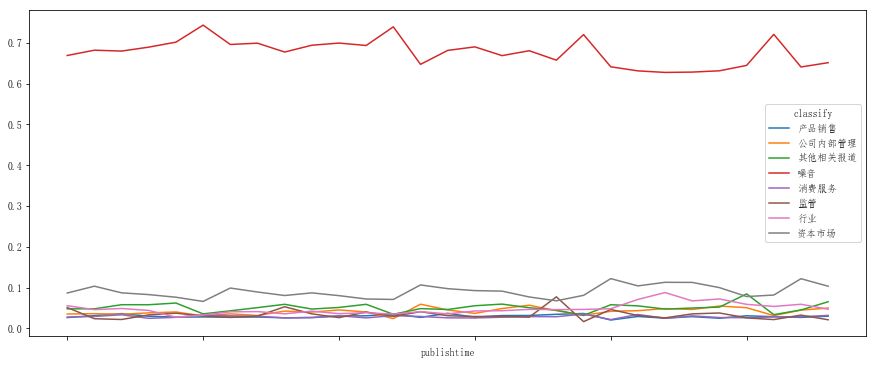

In [90]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

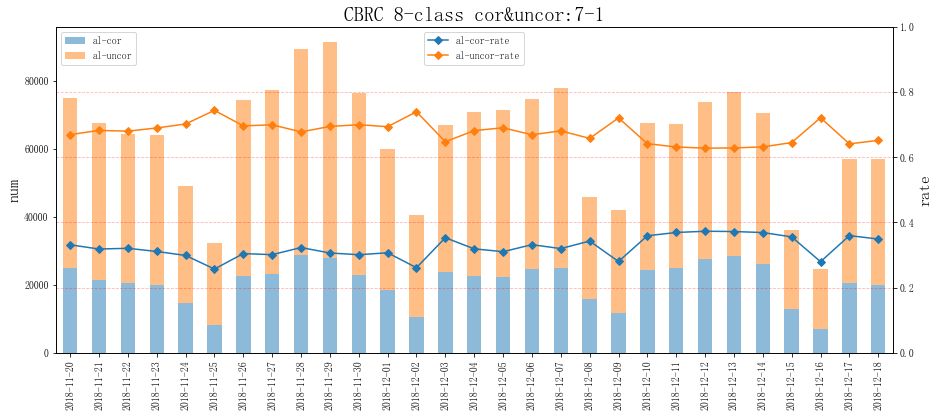

   publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-18  57036   19892     37144        0.349          0.651
27  2018-12-17  57034   20495     36539        0.359          0.641
26  2018-12-16  24706    6901     17805        0.279          0.721
25  2018-12-15  36086   12826     23260        0.355          0.645
24  2018-12-14  70519   25998     44521        0.369          0.631


In [91]:
plot_cor(count_data_7, cbirc_day_thing, "CBRC 8-class cor&uncor:7-1")

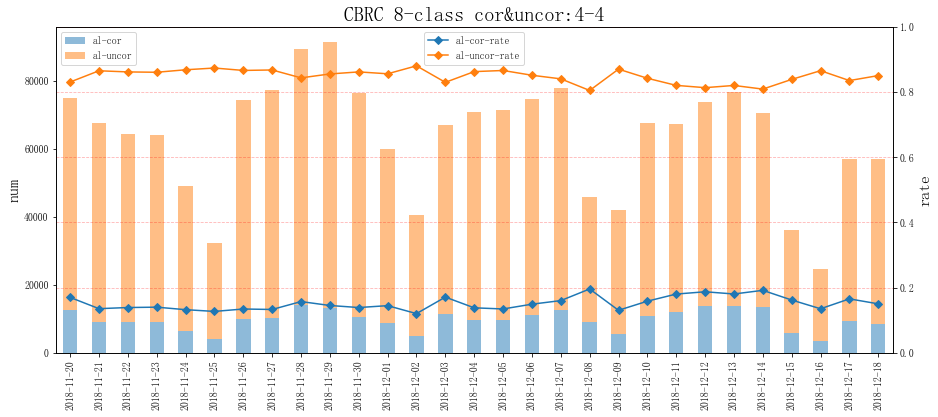

   publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-18    8560  57036     48476        0.150          0.850
27  2018-12-17    9431  57034     47603        0.165          0.835
26  2018-12-16    3336  24706     21370        0.135          0.865
25  2018-12-15    5839  36086     30247        0.162          0.838
24  2018-12-14   13504  70519     57015        0.191          0.809


In [92]:
plot_cor(count_data_4, cbirc_day_thing, "CBRC 8-class cor&uncor:4-4")

### 保监会

In [93]:
class_count = cbirc_count[cbirc_count['type'] == '保监会'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                  总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场                 
publishtime                                                                    
2018-12-18    438    618    424  39505  2074  1780  1980  2331  49150   9645   
2018-12-17    468   3638    502  43627  1917  2768  2766  1854  57540  13913   
2018-12-16    115    493    430  20329   983   581   972   542  24445   4116   
2018-12-15    500    439    363  26124  1416   899   600   434  30775   4651   
2018-12-14   1184   3161    977  44601  5180  3347  2349  2399  63198  18597   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-12-18   0.196 0.804  
2018-12-17   0.242 0.758  
2018-12-16   0.168 0.832  
2018-12-15   0.151 0.849  
2018-12-14   0.294 0.706

count                                                  总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业  资本市场         产品销售   
publishtime                                                                   
2018-12-18    438    618    424  39505  2074  1780  1980  2331  49150 0.009   
2018-12-17    468   3638    502  43627  1917  2768  2766  1854  57540 0.008   
2018-12-16    115    493    430  20329   983   581   972   542  24445 0.005   
2018-12-15    500    439    363  26124  1416   899   600   434  30775 0.016   
2018-12-14   1184   3161    977  44601  5180  3347  2349  2399  63198 0.019   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-12-18   0.013  0.009 0.804 0.042 0.036 0.040 0.047  
2018-12-17   0.063  0.009 0.758 0.033 0.048 0.048 0.032  
2018-12-16   0.020  0.018 0.832 0.040 0.024 0.040 0.022  
2018-12-15   0.014  0.012 0.849 0.046 0.029 0.019 0.014  
2018-12-14   0.050  0.015 0.706 0.082 0.053 0.037 0.038

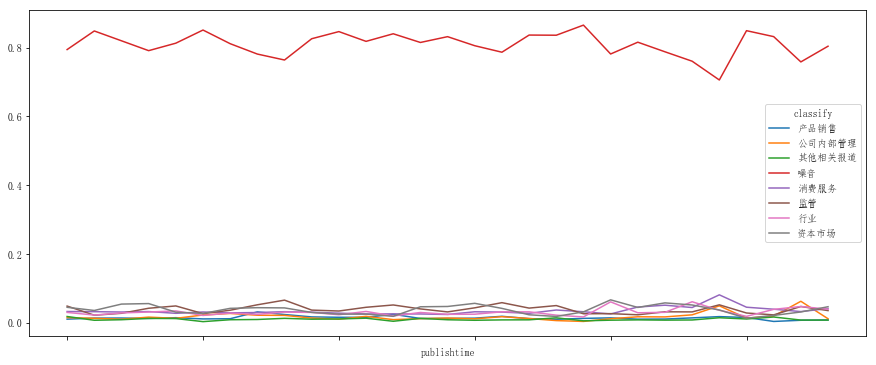

In [94]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

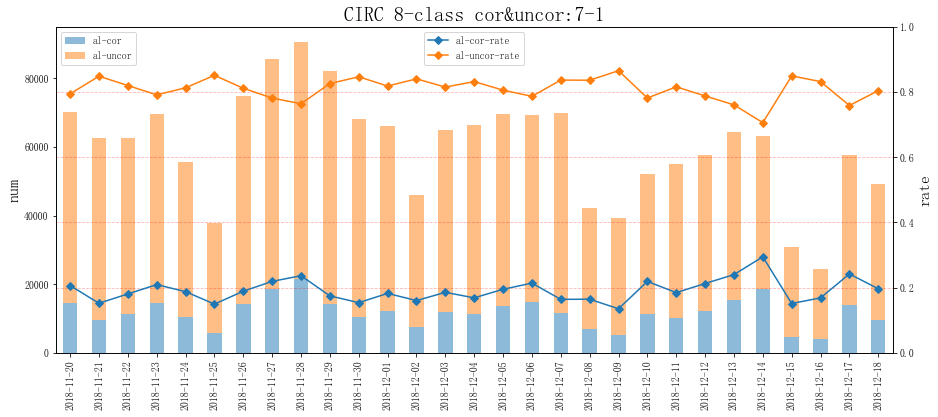

   publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-18  49150    9645     39505        0.196          0.804
27  2018-12-17  57540   13913     43627        0.242          0.758
26  2018-12-16  24445    4116     20329        0.168          0.832
25  2018-12-15  30775    4651     26124        0.151          0.849
24  2018-12-14  63198   18597     44601        0.294          0.706


In [95]:
plot_cor(count_data_7, cbirc_day_thing, "CIRC 8-class cor&uncor:7-1")

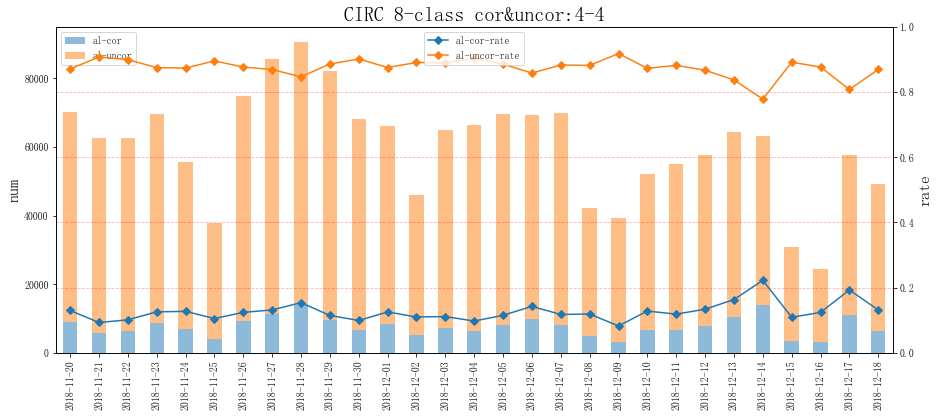

   publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-18    6452  49150     42698        0.131          0.869
27  2018-12-17   11089  57540     46451        0.193          0.807
26  2018-12-16    3029  24445     21416        0.124          0.876
25  2018-12-15    3354  30775     27421        0.109          0.891
24  2018-12-14   14037  63198     49161        0.222          0.778


In [96]:
plot_cor(count_data_4, cbirc_day_thing, "CIRC 8-class cor&uncor:4-4")

### 中国人寿

In [97]:
class_count = cbirc_count[cbirc_count['type'] == '中国人寿'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                            总量   非噪音 非噪音-比例  \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务   监管   行业 资本市场                      
publishtime                                                                    
2018-12-18     33     53     17  2238   20   29  455  248  3093   855  0.276   
2018-12-17     47     90     15  2025   32   38  303  127  2677   652  0.244   
2018-12-16      5     21     10   470   14    6   96   52   674   204  0.303   
2018-12-15      7     24     10   817   14   15  163   17  1067   250  0.234   
2018-12-14     68    182     40  4163   75  150  413  142  5233  1070  0.204   

            噪音-比例  
classify           
publishtime        
2018-12-18  0.724  
2018-12-17  0.756  
2018-12-16  0.697  
2018-12-15  0.766  
2018-12-14  0.796

count                                            总量  rate         \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务   监管   行业 资本市场        产品销售 公司内部管理   
publishtime                                                                    
2018-12-18     33     53     17  2238   20   29  455  248  3093 0.011  0.017   
2018-12-17     47     90     15  2025   32   38  303  127  2677 0.018  0.034   
2018-12-16      5     21     10   470   14    6   96   52   674 0.007  0.031   
2018-12-15      7     24     10   817   14   15  163   17  1067 0.007  0.022   
2018-12-14     68    182     40  4163   75  150  413  142  5233 0.013  0.035   

                                                  
classify    其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                       
2018-12-18   0.005 0.724 0.006 0.009 0.147 0.080  
2018-12-17   0.006 0.756 0.012 0.014 0.113 0.047  
2018-12-16   0.015 0.697 0.021 0.009 0.142 0.077  
2018-12-15   0.009 0.766 0.013 0.014 0.153 0.016  
2018-12-14   0.008 0.796 0.014 0.029 0.079 0.027

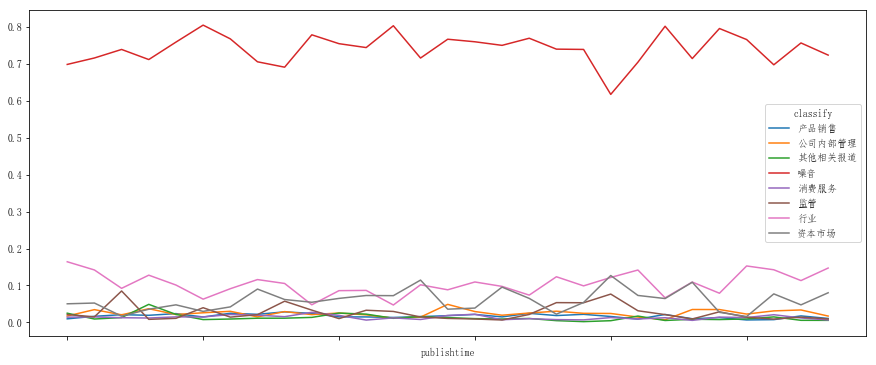

In [98]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

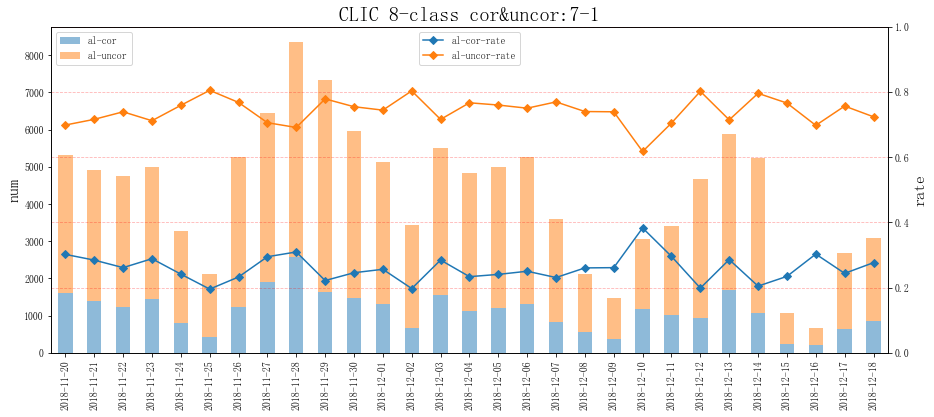

   publishtime   sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-18  3093     855      2238        0.276          0.724
27  2018-12-17  2677     652      2025        0.244          0.756
26  2018-12-16   674     204       470        0.303          0.697
25  2018-12-15  1067     250       817        0.234          0.766
24  2018-12-14  5233    1070      4163        0.204          0.796


In [99]:
plot_cor(count_data_7, cbirc_day_thing, "CLIC 8-class cor&uncor:7-1")

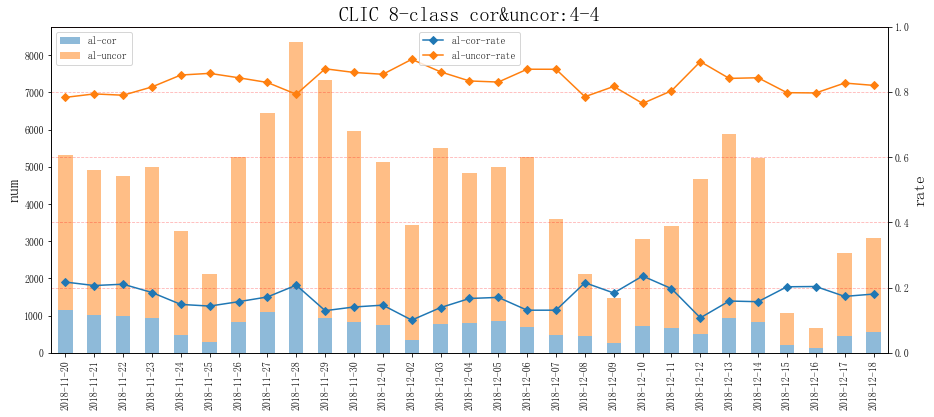

   publishtime  al_cor   sum  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-18     557  3093      2536        0.180          0.820
27  2018-12-17     463  2677      2214        0.173          0.827
26  2018-12-16     137   674       537        0.203          0.797
25  2018-12-15     216  1067       851        0.202          0.798
24  2018-12-14     820  5233      4413        0.157          0.843


In [100]:
plot_cor(count_data_4, cbirc_day_thing, "CLIC 8-class cor&uncor:4-4")

### 建行北分

In [101]:
class_count = cbirc_count[cbirc_count['type'] == '建行北分'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                             总量   非噪音 非噪音-比例  \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务    监管   行业 资本市场                      
publishtime                                                                     
2018-12-18      8     57     46  1789   12   714  153  414  3193  1404  0.440   
2018-12-17      8     86     84  2551   11  1820  275  838  5673  3122  0.550   
2018-12-16      2     49      8   643   10   164  317  303  1496   853  0.570   
2018-12-15      5     74     18  1703   17   473  367  333  2990  1287  0.430   
2018-12-14     25    118     43  2114   48   670  888  876  4782  2668  0.558   

            噪音-比例  
classify           
publishtime        
2018-12-18  0.560  
2018-12-17  0.450  
2018-12-16  0.430  
2018-12-15  0.570  
2018-12-14  0.442

count                                             总量  rate         \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务    监管   行业 资本市场        产品销售 公司内部管理   
publishtime                                                                     
2018-12-18      8     57     46  1789   12   714  153  414  3193 0.003  0.018   
2018-12-17      8     86     84  2551   11  1820  275  838  5673 0.001  0.015   
2018-12-16      2     49      8   643   10   164  317  303  1496 0.001  0.033   
2018-12-15      5     74     18  1703   17   473  367  333  2990 0.002  0.025   
2018-12-14     25    118     43  2114   48   670  888  876  4782 0.005  0.025   

                                                  
classify    其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                       
2018-12-18   0.014 0.560 0.004 0.224 0.048 0.130  
2018-12-17   0.015 0.450 0.002 0.321 0.048 0.148  
2018-12-16   0.005 0.430 0.007 0.110 0.212 0.203  
2018-12-15   0.006 0.570 0.006 0.158 0.123 0.111  
2018-12-14   0.009 0.442 0.010 0.140 0.186 0.183

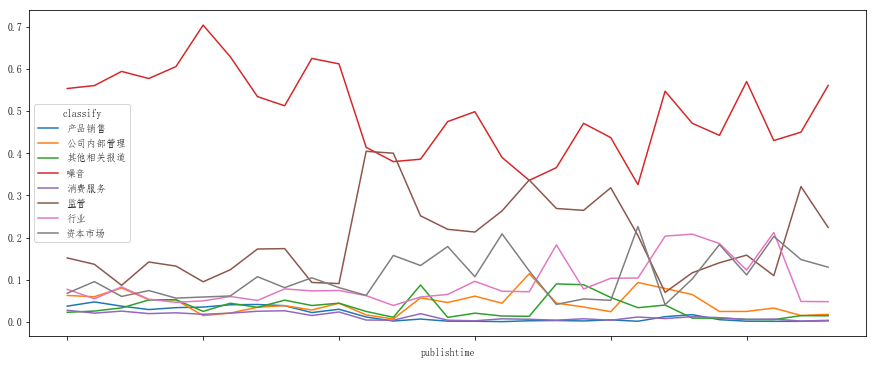

In [102]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

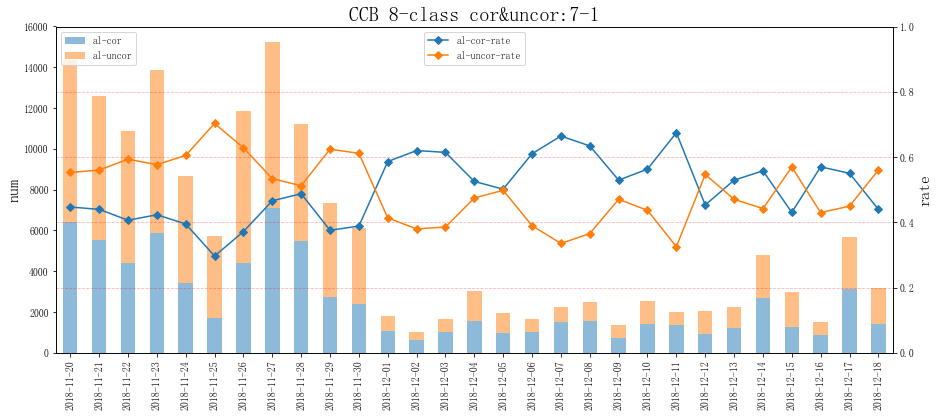

   publishtime   sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-18  3193    1404      1789        0.440          0.560
27  2018-12-17  5673    3122      2551        0.550          0.450
26  2018-12-16  1496     853       643        0.570          0.430
25  2018-12-15  2990    1287      1703        0.430          0.570
24  2018-12-14  4782    2668      2114        0.558          0.442


In [103]:
plot_cor(count_data_7, cbirc_day_thing, "CCB 8-class cor&uncor:7-1")

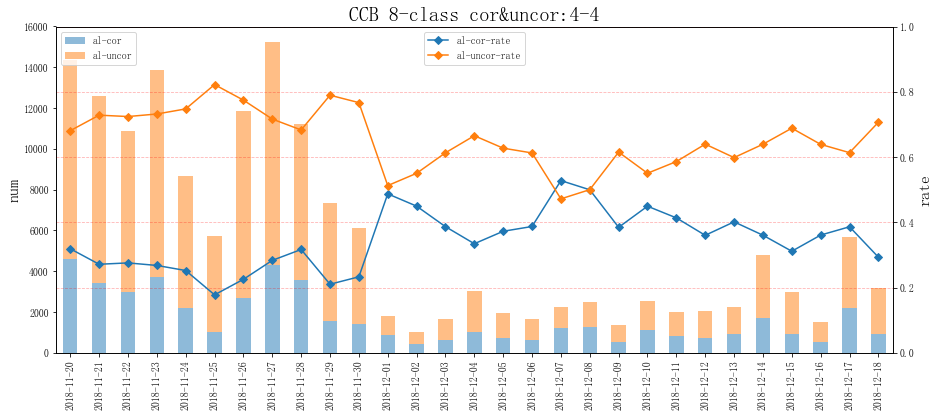

   publishtime  al_cor   sum  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-18     936  3193      2257        0.293          0.707
27  2018-12-17    2192  5673      3481        0.386          0.614
26  2018-12-16     540  1496       956        0.361          0.639
25  2018-12-15     931  2990      2059        0.311          0.689
24  2018-12-14    1724  4782      3058        0.361          0.639


In [104]:
plot_cor(count_data_4, cbirc_day_thing, "CCB 8-class cor&uncor:4-4")

### 中国人保

In [105]:
class_count = cbirc_count[cbirc_count['type'] == '中国人保'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                       总量  \
classify       交通 产品销售 公司内部管理 其他相关报道    噪音 消费服务   环保   监管   行业 资本市场          
publishtime                                                                  
2018-12-18   6191   23     79    104  5683  230  129  541  363   65  13408   
2018-12-17   8144   19    195     52  6393  143  176  236  303   78  15739   
2018-12-16   8025    5      8     35  6652  220   98   30  124    4  15201   
2018-12-15   4139    3     31     83  7414  108  265   18   67   16  12144   
2018-12-14   4604   30    872     57  9173  106  185  130  505   78  15740   

              非噪音 非噪音-比例 噪音-比例  
classify                        
publishtime                     
2018-12-18   7725  0.576 0.424  
2018-12-17   9346  0.594 0.406  
2018-12-16   8549  0.562 0.438  
2018-12-15   4730  0.389 0.611  
2018-12-14   6567  0.417 0.583

count                                                    ...   \
classify       交通 产品销售 公司内部管理 其他相关报道    噪音 消费服务   环保   监管   行业 资本市场  ...    
publishtime                                                          ...    
2018-12-18   6191   23     79    104  5683  230  129  541  363   65  ...    
2018-12-17   8144   19    195     52  6393  143  176  236  303   78  ...    
2018-12-16   8025    5      8     35  6652  220   98   30  124    4  ...    
2018-12-15   4139    3     31     83  7414  108  265   18   67   16  ...    
2018-12-14   4604   30    872     57  9173  106  185  130  505   78  ...    

             rate                                                          
classify       交通  产品销售 公司内部管理 其他相关报道    噪音  消费服务    环保    监管    行业  资本市场  
publishtime                                                                
2018-12-18  0.462 0.002  0.006  0.008 0.424 0.017 0.010 0.040 0.027 0.005  
2018-12-17  0.517 0.001  0.012  0.003 0.406 0.009 0.011 0.015 0.019 0.005  
2018-12-16  0.528 0.000  0.001  0.002 0.438 0.014 0.006 0.002 0.008 0.000  
2018-12-15  0.341 0.000  0.003  0.007 0.611 0.009 0.022 0.001 0.006 0.001  
2018-12-14  0.293 0.002  0.055  0.004 0.583 0.007 0.012 0.008 0.032 0.005  

[5 rows x 21 columns]

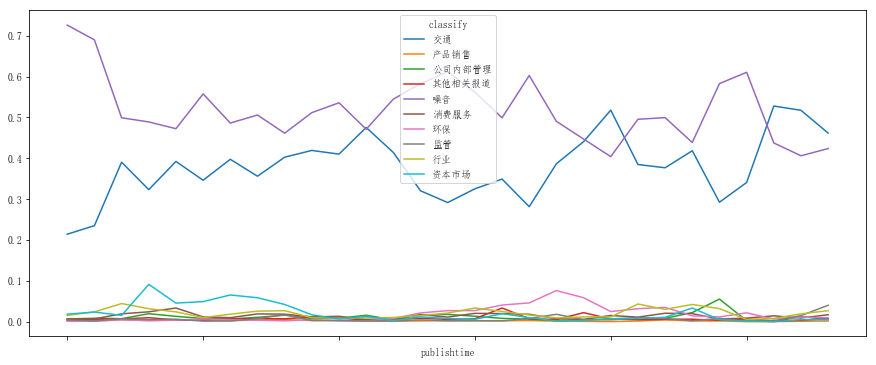

In [106]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

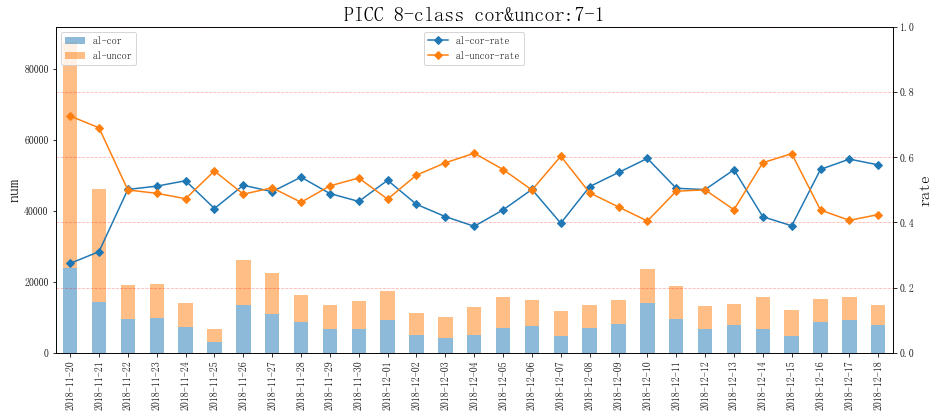

   publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-18  13408    7725      5683        0.576          0.424
27  2018-12-17  15739    9346      6393        0.594          0.406
26  2018-12-16  15201    8549      6652        0.562          0.438
25  2018-12-15  12144    4730      7414        0.389          0.611
24  2018-12-14  15740    6567      9173        0.417          0.583


In [107]:
plot_cor(count_data_7, cbirc_day_thing, "PICC 8-class cor&uncor:7-1")

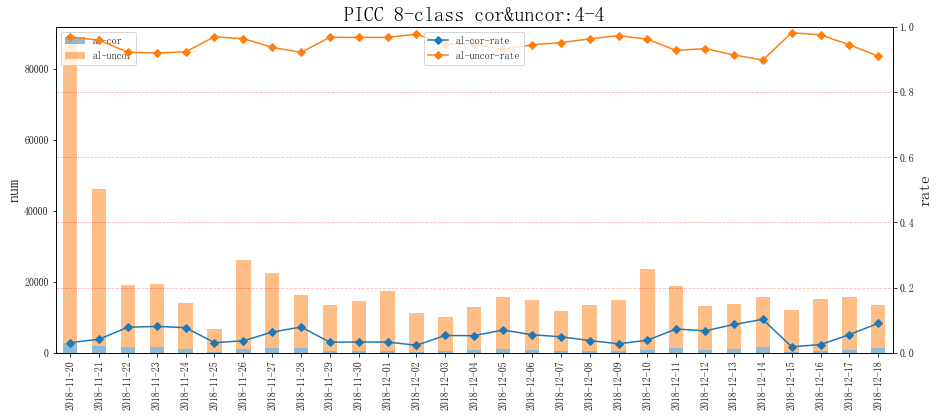

   publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
28  2018-12-18    1213  13408     12195        0.090          0.910
27  2018-12-17     877  15739     14862        0.056          0.944
26  2018-12-16     382  15201     14819        0.025          0.975
25  2018-12-15     224  12144     11920        0.018          0.982
24  2018-12-14    1613  15740     14127        0.102          0.898


In [108]:
plot_cor(count_data_4, cbirc_day_thing, "PICC 8-class cor&uncor:4-4")

## 倾向性
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：

### 银监会

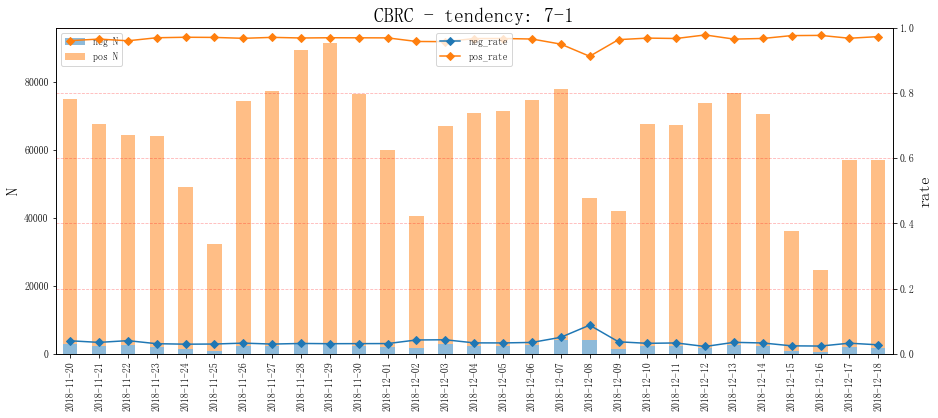

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2018-12-18  1568  55468  57036     0.027     0.973
27  2018-12-17  1856  55178  57034     0.033     0.967
26  2018-12-16   587  24119  24706     0.024     0.976
25  2018-12-15   880  35206  36086     0.024     0.976
24  2018-12-14  2341  68178  70519     0.033     0.967


In [127]:
plot_tend(tend_count[tend_count['type'] == '银监会'].drop('type', axis = 1), cbirc_day_thing, "CBRC - tendency: 7-1")

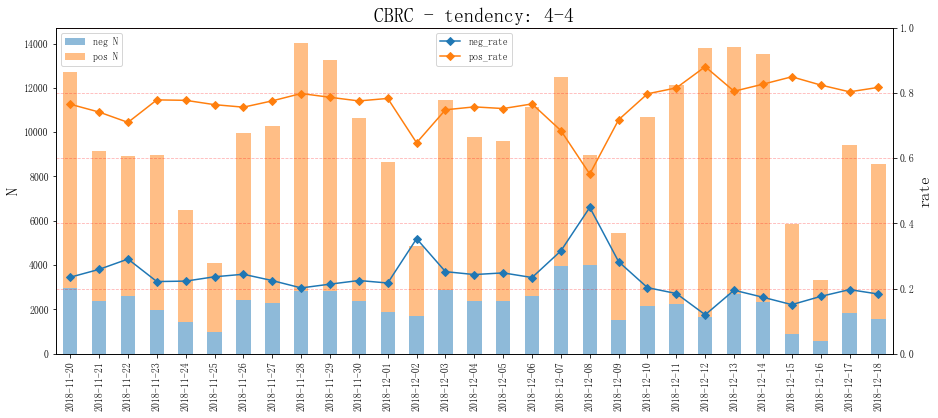

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2018-12-18  1568   6992   8560     0.183     0.817
27  2018-12-17  1856   7575   9431     0.197     0.803
26  2018-12-16   587   2749   3336     0.176     0.824
25  2018-12-15   880   4959   5839     0.151     0.849
24  2018-12-14  2341  11163  13504     0.173     0.827


In [128]:
plot_tend(tend_count_4[tend_count_4['type'] == '银监会'].drop('type', axis = 1), cbirc_day_thing, "CBRC - tendency: 4-4")

### 保监会

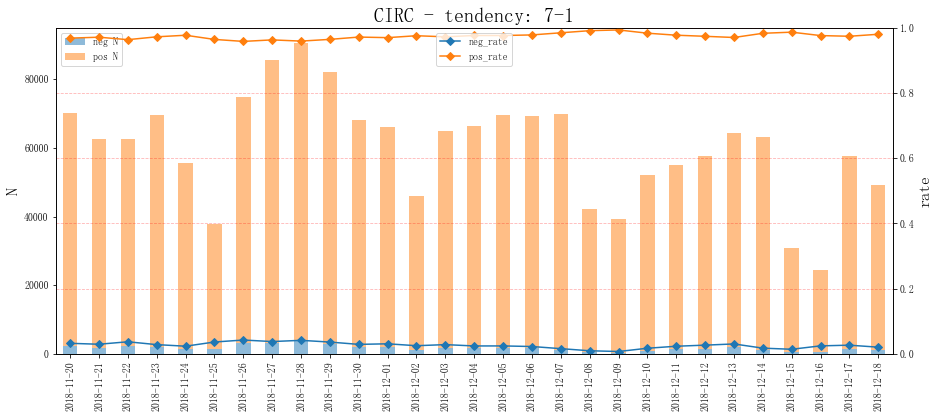

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2018-12-18   998  48152  49150     0.020     0.980
27  2018-12-17  1521  56019  57540     0.026     0.974
26  2018-12-16   595  23850  24445     0.024     0.976
25  2018-12-15   427  30348  30775     0.014     0.986
24  2018-12-14  1095  62103  63198     0.017     0.983


In [129]:
plot_tend(tend_count[tend_count['type'] == '保监会'].drop('type', axis = 1), cbirc_day_thing, "CIRC - tendency: 7-1")

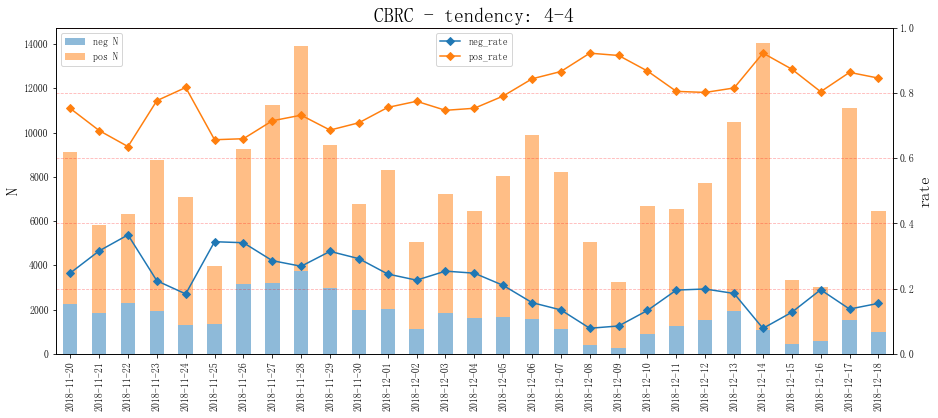

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2018-12-18   998   5454   6452     0.155     0.845
27  2018-12-17  1521   9568  11089     0.137     0.863
26  2018-12-16   595   2434   3029     0.196     0.804
25  2018-12-15   427   2927   3354     0.127     0.873
24  2018-12-14  1095  12942  14037     0.078     0.922


In [130]:
plot_tend(tend_count_4[tend_count_4['type'] == '保监会'].drop('type', axis = 1), cbirc_day_thing, "CIRC - tendency: 4-4")

### 中国人寿

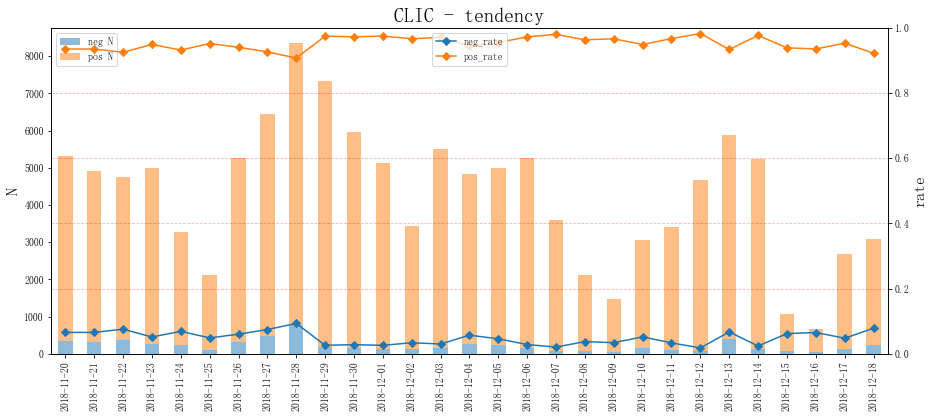

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2018-12-18  242  2851  3093     0.078     0.922
27  2018-12-17  128  2549  2677     0.048     0.952
26  2018-12-16   44   630   674     0.065     0.935
25  2018-12-15   66  1001  1067     0.062     0.938
24  2018-12-14  125  5108  5233     0.024     0.976


In [131]:
plot_tend(tend_count[tend_count['type'] == '中国人寿'].drop('type', axis = 1), cbirc_day_thing, "CLIC - tendency: 7-1")

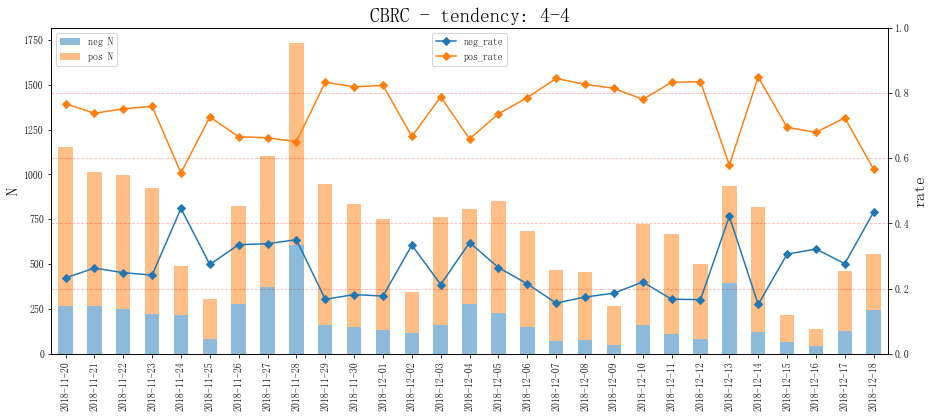

   publishtime  neg  pos  sum  neg_rate  pos_rate
28  2018-12-18  242  315  557     0.434     0.566
27  2018-12-17  128  335  463     0.276     0.724
26  2018-12-16   44   93  137     0.321     0.679
25  2018-12-15   66  150  216     0.306     0.694
24  2018-12-14  124  696  820     0.151     0.849


In [132]:
plot_tend(tend_count_4[tend_count_4['type'] == '中国人寿'].drop('type', axis = 1), cbirc_day_thing, "CLIC - tendency: 4-4")

### 建行北分

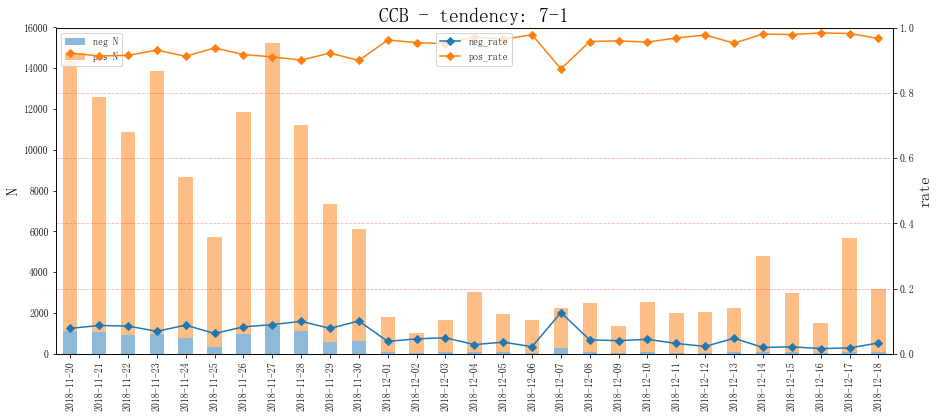

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2018-12-18  106  3087  3193     0.033     0.967
27  2018-12-17  102  5571  5673     0.018     0.982
26  2018-12-16   24  1472  1496     0.016     0.984
25  2018-12-15   64  2926  2990     0.021     0.979
24  2018-12-14   93  4689  4782     0.019     0.981


In [135]:
plot_tend(tend_count[tend_count['type'] == '建行北分'].drop('type', axis = 1), cbirc_day_thing, "CCB - tendency: 7-1")

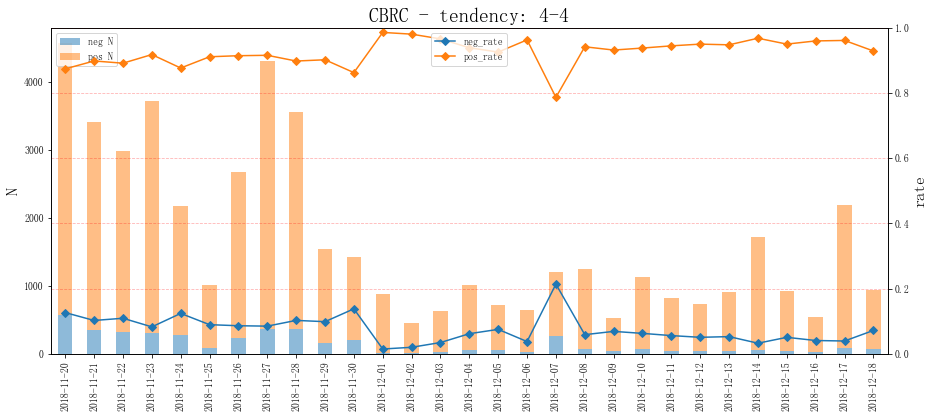

   publishtime  neg   pos   sum  neg_rate  pos_rate
28  2018-12-18   67   869   936     0.072     0.928
27  2018-12-17   86  2106  2192     0.039     0.961
26  2018-12-16   22   518   540     0.041     0.959
25  2018-12-15   47   884   931     0.050     0.950
24  2018-12-14   56  1668  1724     0.032     0.968


In [136]:
plot_tend(tend_count_4[tend_count_4['type'] == '建行北分'].drop('type', axis = 1), cbirc_day_thing, "CCB - tendency: 4-4")

### 中国人保

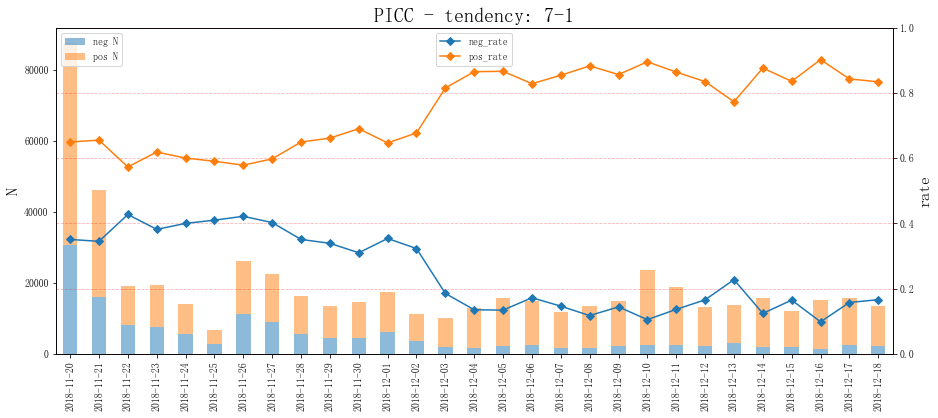

   publishtime   neg    pos    sum  neg_rate  pos_rate
28  2018-12-18  2226  11182  13408     0.166     0.834
27  2018-12-17  2475  13264  15739     0.157     0.843
26  2018-12-16  1492  13709  15201     0.098     0.902
25  2018-12-15  1999  10145  12144     0.165     0.835
24  2018-12-14  1950  13790  15740     0.124     0.876


In [138]:
plot_tend(tend_count[tend_count['type'] == '中国人保'].drop('type', axis = 1), cbirc_day_thing, "PICC - tendency: 7-1")

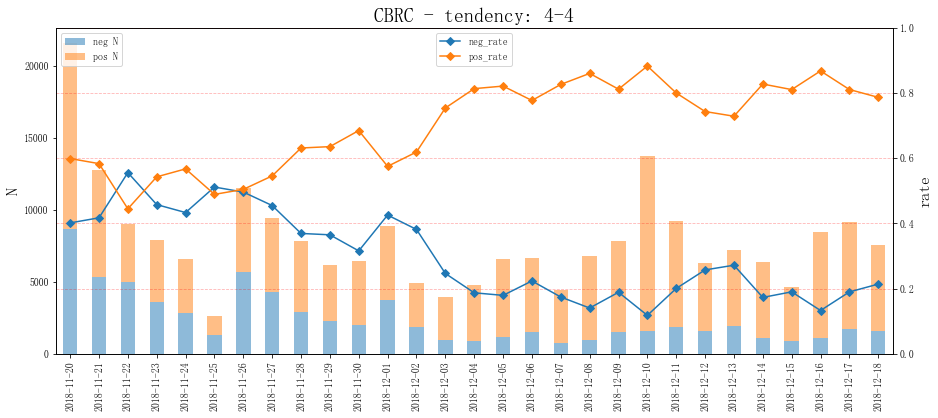

   publishtime   neg   pos   sum  neg_rate  pos_rate
28  2018-12-18  1610  5923  7533     0.214     0.786
27  2018-12-17  1745  7452  9197     0.190     0.810
26  2018-12-16  1129  7376  8505     0.133     0.867
25  2018-12-15   879  3749  4628     0.190     0.810
24  2018-12-14  1107  5295  6402     0.173     0.827


In [139]:
plot_tend(tend_count_4[tend_count_4['type'] == '中国人保'].drop('type', axis = 1), cbirc_day_thing, "PICC - tendency: 4-4")

## 补录和预警
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：
- 20191219
  - 银监会：
  - 保监会：
  - 中国人寿：
  - 建行北分：
  - 中国人保：

### 银监会

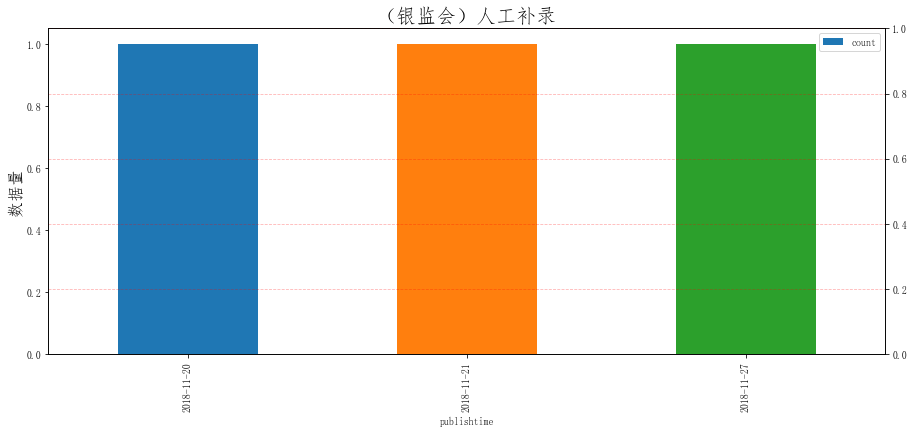

  publishtime  count
2  2018-11-27      1
1  2018-11-21      1
0  2018-11-20      1


In [163]:
plot_add(cbirc_add[cbirc_add['type'] == '银监会'], cbirc_day_thing, "（银监会）人工补录")

### 保监会

In [165]:
# plot_add(cbirc_add[cbirc_add['type'] == '保监会'], cbirc_day_thing, "（保监会）人工补录")

### 中国人寿

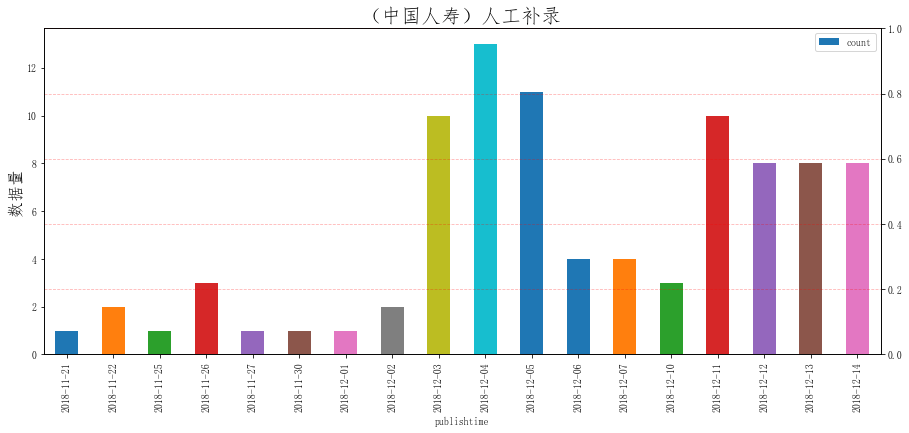

   publishtime  count
17  2018-12-14      8
16  2018-12-13      8
15  2018-12-12      8
14  2018-12-11     10
13  2018-12-10      3


In [166]:
plot_add(cbirc_add[cbirc_add['type'] == '中国人寿'], cbirc_day_thing, "（中国人寿）人工补录")

### 建行北分

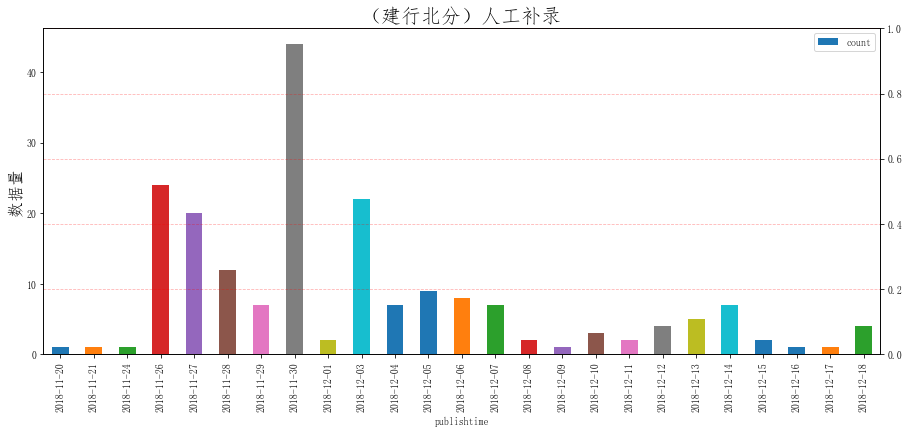

   publishtime  count
24  2018-12-18      4
23  2018-12-17      1
22  2018-12-16      1
21  2018-12-15      2
20  2018-12-14      7


In [167]:
plot_add(cbirc_add[cbirc_add['type'] == '建行北分'], cbirc_day_thing, "（建行北分）人工补录")

### 中国人保

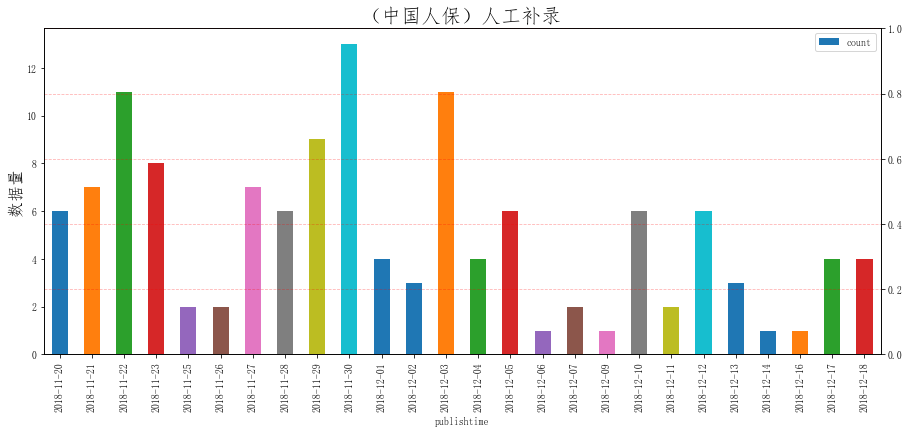

   publishtime  count
25  2018-12-18      4
24  2018-12-17      4
23  2018-12-16      1
22  2018-12-14      1
21  2018-12-13      3


In [168]:
plot_add(cbirc_add[cbirc_add['type'] == '中国人保'], cbirc_day_thing, "（中国人保）人工补录")